In [ ]:
pip install node2vec graphviz numpy scikit-learn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import time
import random
import gzip
import urllib.request
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms.community import modularity, greedy_modularity_communities

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from node2vec import Node2Vec
from sklearn.manifold import TSNE

from scipy.stats import powerlaw
from matplotlib.patches import Patch

# ca-GrQc

In [5]:
def download_and_load_graph():
    url = "https://snap.stanford.edu/data/ca-GrQc.txt.gz"
    file_name = "ca-GrQc.txt.gz"

    if not os.path.exists(file_name):
        print("Downloading dataset...")
        urllib.request.urlretrieve(url, file_name)

    print("Processing and loading graph...")
    edges = []
    with gzip.open(file_name, 'rt') as f:
        for line in f:
            if line.startswith('#') or not line.strip():
                continue  # Skip comments or empty lines
            parts = line.strip().split()
            try:
                edges.append(tuple(map(int, parts)))  # Convert node IDs to integers only if valid
            except ValueError:
                continue  # Skip lines where conversion to int fails

    graph = nx.Graph()
    graph.add_edges_from(edges)
    print(f"Graph loaded with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")
    return graph


In [2]:
def preprocess_graph(graph):
    print("Starting graph preprocessing...")

    # Handle Missing or Incomplete Data
    print("Checking for isolated nodes...")
    isolates = list(nx.isolates(graph))
    if isolates:
        print(f"Found {len(isolates)} isolated nodes. Removing them...")
        graph.remove_nodes_from(isolates)

    print("Checking for self-loops...")
    self_loops = list(nx.selfloop_edges(graph))
    if self_loops:
        print(f"Found {len(self_loops)} self-loops. Removing them...")
        graph.remove_edges_from(self_loops)

    print("Checking for duplicate edges...")
    # Since NetworkX automatically handles multiple edges between two nodes in a simple Graph,
    # this step is conceptual unless using a MultiGraph
    if isinstance(graph, nx.MultiGraph):
        original_edge_count = sum(1 for _ in graph.edges())
        graph = nx.Graph(graph)  # Converts MultiGraph to Graph, thus removing duplicate edges
        new_edge_count = graph.number_of_edges()
        duplicate_edges_count = original_edge_count - new_edge_count
        print(f"Found {duplicate_edges_count} duplicate edges. Converted to simple graph.")
    else:
        print("No duplicate edges found; the graph is already a simple graph.")

    # Standardize Node and Edge IDs
    print("Normalizing node IDs...")
    mapping = {node: i for i, node in enumerate(sorted(graph.nodes()))}
    graph = nx.relabel_nodes(graph, mapping)

    # Ensure the graph is undirected
    print("Ensuring graph is undirected...")
    if nx.is_directed(graph):
        graph = graph.to_undirected()
        print("Converted to undirected graph.")
    else:
        print("Graph is already undirected.")

    print(f"Preprocessing complete. Graph now has {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")
    return graph


In [3]:
def compute_graph_metrics(graph):
    print("Computing Graph Metrics...")

    # Basic Graph Metrics
    properties = {
        "Number of Nodes": graph.number_of_nodes(),
        "Number of Edges": graph.number_of_edges(),
        "Density": nx.density(graph),
    }

    # Connected Components
    connected_components = list(nx.connected_components(graph))
    properties["Number of Connected Components"] = len(connected_components)
    largest_component_size = max(len(component) for component in connected_components) if connected_components else 0
    properties["Size of Largest Connected Component"] = largest_component_size

    # Advanced Metrics
    print("Calculating centrality measures...")
    degree_centrality = nx.degree_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    properties["Max Degree Centrality"] = max(degree_centrality.values())
    properties["Max Closeness Centrality"] = max(closeness_centrality.values())
    properties["Max Betweenness Centrality"] = max(betweenness_centrality.values())

    # Clustering Coefficient
    properties["Clustering Coefficient"] = nx.average_clustering(graph)

    # Check if graph is connected and calculate Diameter and Path Length
    if nx.is_connected(graph):
        properties["Diameter"] = nx.diameter(graph)
        properties["Average Path Length"] = nx.average_shortest_path_length(graph)
        properties["Triangles"] = sum(nx.triangles(graph).values()) // 3

    # Print all metrics
    print("\n".join([f"{k}: {v}" for k, v in properties.items()]))

    return properties


In [ ]:
# Measure re-identification risk
def measure_privacy_preservation(original_graph, perturbed_graph):
    print("Measuring privacy preservation...")
    
    original_edges = set(original_graph.edges())
    perturbed_edges = set(perturbed_graph.edges())

    # Calculate the percentage of edges re-identified
    common_edges = original_edges.intersection(perturbed_edges)
    reidentification_rate = len(common_edges) / len(original_edges) * 100

    print(f"Edge re-identification rate: {reidentification_rate:.2f}%")
    return reidentification_rate

# Evaluate structural and attribute preservation
def evaluate_data_utility(original_graph, perturbed_graph):
    print("Evaluating data utility...")

    def extract_features(graph):
        degrees = dict(graph.degree())
        return [(node, degrees[node]) for node in graph.nodes()]

    original_features = extract_features(original_graph)
    perturbed_features = extract_features(perturbed_graph)

    nodes_original, degrees_original = zip(*original_features)
    nodes_perturbed, degrees_perturbed = zip(*perturbed_features)

    # Generate synthetic labels for classification (based on degree threshold)
    threshold = sum(degrees_original) / len(degrees_original)
    labels_original = [1 if degree > threshold else 0 for degree in degrees_original]

    # Train-test split and model training on the original graph
    X_train, X_test, y_train, y_test = train_test_split(degrees_original, labels_original, test_size=0.3, random_state=42)
    clf = RandomForestClassifier(random_state=42)
    clf.fit([[x] for x in X_train], y_train)
    y_pred = clf.predict([[x] for x in X_test])
    original_accuracy = accuracy_score(y_test, y_pred)

    # Evaluate the trained model on the perturbed graph
    y_perturbed_pred = clf.predict([[x] for x in degrees_perturbed])
    anonymized_accuracy = accuracy_score(labels_original, y_perturbed_pred)

    print(f"Original accuracy: {original_accuracy:.2f}")
    print(f"Anonymized accuracy: {anonymized_accuracy:.2f}")
    return original_accuracy, anonymized_accuracy

# Anonymization Cost: Measure computational cost
def measure_anonymization_cost(anonymization_function, graph):
    print("Measuring anonymization cost...")
    start_time = time.time()
    perturbed_graph = anonymization_function(graph)
    elapsed_time = time.time() - start_time
    print(f"Time taken for anonymization: {elapsed_time:.2f} seconds")
    return elapsed_time, perturbed_graph

# Robustness: Test against structural attacks
def evaluate_robustness(original_graph, perturbed_graph):
    print("Evaluating robustness...")

    original_degrees = sorted([degree for _, degree in original_graph.degree()])
    perturbed_degrees = sorted([degree for _, degree in perturbed_graph.degree()])

    # Measure similarity of degree distributions
    degree_difference = sum(abs(o - p) for o, p in zip(original_degrees, perturbed_degrees))
    robustness_score = 1 - (degree_difference / sum(original_degrees))

    print(f"Robustness (degree distribution similarity): {robustness_score:.2f}")
    return robustness_score

In [ ]:
def evaluate_graph_similarity(original_graph, anonymized_graph):
    """
    Evaluate additional similarity metrics between the original and anonymized graphs.
    """
    results = {}

    # Degree Distribution Correlation
    original_degrees = [degree for _, degree in original_graph.degree()]
    anonymized_degrees = [degree for _, degree in anonymized_graph.degree()]
    results["Degree Distribution Correlation"] = (
        np.corrcoef(original_degrees, anonymized_degrees)[0, 1]
        if len(original_degrees) > 1
        else None
    )

    # Clustering Coefficient Correlation
    original_clustering = list(nx.clustering(original_graph).values())
    anonymized_clustering = list(nx.clustering(anonymized_graph).values())
    results["Clustering Coefficient Correlation"] = (
        np.corrcoef(original_clustering, anonymized_clustering)[0, 1]
        if len(original_clustering) > 1
        else None
    )

    # Triangles Similarity
    original_triangles = list(nx.triangles(original_graph).values())
    anonymized_triangles = list(nx.triangles(anonymized_graph).values())
    results["Triangles Similarity"] = (
        np.corrcoef(original_triangles, anonymized_triangles)[0, 1]
        if len(original_triangles) > 1
        else None
    )

    # Modularity Difference
    try:
        from networkx.algorithms.community import greedy_modularity_communities, modularity

        original_communities = list(greedy_modularity_communities(original_graph))
        anonymized_communities = list(greedy_modularity_communities(anonymized_graph))
        original_modularity = modularity(original_graph, original_communities)
        anonymized_modularity = modularity(anonymized_graph, anonymized_communities)
        results["Modularity Difference"] = abs(original_modularity - anonymized_modularity)
    except ImportError:
        results["Modularity Difference"] = None

    return results

In [ ]:
def evaluate_graph_anonymization(original_graph, anonymization_function, *args, **kwargs):
    print("Applying anonymization...")
    start_time = time.time()
    anonymized_graph = anonymization_function(original_graph, *args, **kwargs)
    anonymization_time = time.time() - start_time
    print(f"Anonymization completed in {anonymization_time:.2f} seconds.")

    print("Evaluating privacy preservation...")
    reidentification_rate = measure_privacy_preservation(original_graph, anonymized_graph)

    print("Evaluating data utility...")
    original_accuracy, anon_accuracy = evaluate_data_utility(original_graph, anonymized_graph)

    print("Evaluating robustness...")
    robustness_score = evaluate_robustness(original_graph, anonymized_graph)

    print("Evaluating structural similarity...")
    similarity_metrics = evaluate_graph_similarity(original_graph, anonymized_graph)

    results = {
        "Anonymization Time": anonymization_time,
        "Re-Identification Rate": reidentification_rate,
        "Original Accuracy": original_accuracy,
        "Anonymized Accuracy": anon_accuracy,
        "Robustness Score": robustness_score,
        **similarity_metrics,  # Adding all the similarity metrics
    }

    return results

### 0. Applying random pertubation

In [ ]:
# Function to apply random perturbation
def apply_random_perturbation(graph, perturbation_rate=0.1):
    """
    Apply random perturbation by randomly adding and removing edges.

    :param graph: A NetworkX graph.
    :param perturbation_rate: Fraction of edges to perturb.
    :return: A perturbed graph.
    """
    perturbed_graph = graph.copy()
    edges = list(perturbed_graph.edges())
    nodes = list(perturbed_graph.nodes())
    num_perturbations = int(perturbation_rate * len(edges))

    # Randomly remove edges
    for _ in range(num_perturbations):
        if edges:
            edge_to_remove = random.choice(edges)
            perturbed_graph.remove_edge(*edge_to_remove)
            edges.remove(edge_to_remove)

    # Randomly add edges
    for _ in range(num_perturbations):
        u, v = random.sample(nodes, 2)
        if not perturbed_graph.has_edge(u, v):
            perturbed_graph.add_edge(u, v)

    return perturbed_graph

### 1. Using differential privacy

In [ ]:
def add_differential_privacy_to_degrees(graph, epsilon=0.3):
    """
    Add differential privacy to the node degrees of a graph with topology-aware noise.

    :param graph: A NetworkX graph.
    :param epsilon: Privacy budget, a smaller epsilon means more privacy.
    :return: A perturbed graph with noisy degrees and edges.
    """
    sensitivity = 1  # Sensitivity of the degree function is 1
    scale = sensitivity / epsilon

    # Create a copy of the graph to perturb
    perturbed_graph = nx.Graph()
    perturbed_graph.add_nodes_from(graph.nodes())

    # Topology-aware noise: Adjust noise based on centrality metrics
    degree_centrality = nx.degree_centrality(graph)
    for node in graph.nodes():
        true_degree = graph.degree[node]
        node_centrality = degree_centrality[node]

        # Scale noise inversely with centrality to obfuscate high-centrality nodes less
        adjusted_scale = scale / (1 + node_centrality)
        noise = np.random.laplace(0, adjusted_scale, 1)[0]  # Generate Laplace noise
        noisy_degree = max(0, int(true_degree + noise))  # Ensure non-negative degree

        # Add or remove edges to achieve noisy degree
        neighbors = list(graph.neighbors(node))
        random.shuffle(neighbors)
        # Add edges
        while len(neighbors) < noisy_degree:
            potential_neighbor = random.choice(list(graph.nodes()))
            if node != potential_neighbor and not perturbed_graph.has_edge(node, potential_neighbor):
                perturbed_graph.add_edge(node, potential_neighbor)
                neighbors.append(potential_neighbor)
        # Remove excess edges if noisy degree is less than the true degree
        while len(neighbors) > noisy_degree:
            neighbor = neighbors.pop()
            if perturbed_graph.has_edge(node, neighbor):
                perturbed_graph.remove_edge(node, neighbor)

    return perturbed_graph

def add_topology_preserving_edges(graph, k=2):
    """
    Add edges to preserve connectivity while obfuscating structure selectively.

    :param graph: A NetworkX graph.
    :param k: Number of random edges to add for each low-centrality node.
    :return: A graph with additional random edges.
    """
    degree_centrality = nx.degree_centrality(graph)
    for node in graph.nodes():
        if degree_centrality[node] < 0.1:  # Focus on low-centrality nodes
            for _ in range(k):
                potential_neighbor = random.choice(list(graph.nodes()))
                if node != potential_neighbor and not graph.has_edge(node, potential_neighbor):
                    graph.add_edge(node, potential_neighbor)

    return graph

def anonymize_and_evaluate(graph):
    epsilon = 0.3  # Moderate privacy budget for better utility-privacy balance

    # Apply differential privacy to the graph
    print("Anonymizing graph with differential privacy...")
    perturbed_graph = add_differential_privacy_to_degrees(graph, epsilon)

    # Add topology-preserving edges
    print("Adding topology-preserving edges...")
    perturbed_graph = add_topology_preserving_edges(perturbed_graph, k=2)

    # Evaluate the anonymized graph
    results = evaluate_graph_anonymization(graph, add_differential_privacy_to_degrees, epsilon=epsilon)
    return results

# Download and preprocess the graph
graph = download_and_load_graph()
preprocessed_graph = preprocess_graph(graph)

# Perform anonymization and evaluation
results = anonymize_and_evaluate(preprocessed_graph)

# Print results
print("\nAnonymization Results:")
for key, value in results.items():
    print(f"{key}: {value}")


Processing and loading graph...
Graph loaded with 5242 nodes and 14496 edges.
Starting graph preprocessing...
Checking for isolated nodes...
Checking for self-loops...
Found 12 self-loops. Removing them...
Checking for duplicate edges...
No duplicate edges found; the graph is already a simple graph.
Normalizing node IDs...
Ensuring graph is undirected...
Graph is already undirected.
Preprocessing complete. Graph now has 5242 nodes and 14484 edges.
Anonymizing graph with differential privacy...
Adding topology-preserving edges...
Applying anonymization...
Anonymization completed in 0.19 seconds.
Evaluating privacy preservation...
Measuring privacy preservation...
Edge re-identification rate: 0.05%
Evaluating data utility...
Evaluating data utility...
Original accuracy: 1.00
Perturbed accuracy: 0.67
Evaluating robustness...
Evaluating robustness...
Robustness (degree distribution similarity): 0.52
Evaluating structural similarity...

Anonymization Results:
Anonymization Time: 0.188544034

### Visualization function

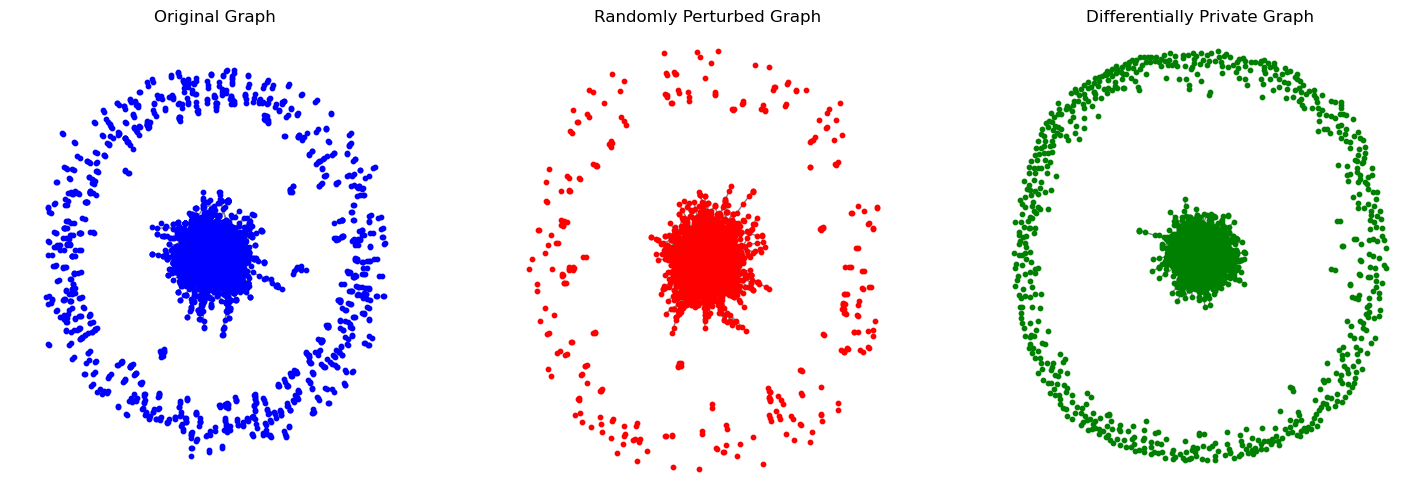

In [22]:
def visualize_graph_comparison(original_graph, random_perturbed_graph, differential_private_graph):
    """
    Visualize the original graph, randomly perturbed graph, and differentially private graph.

    :param original_graph: Original NetworkX graph.
    :param random_perturbed_graph: Randomly perturbed graph.
    :param differential_private_graph: Differentially private graph.
    """
    plt.figure(figsize=(18, 6))

    # Original graph
    plt.subplot(1, 3, 1)
    nx.draw(
        original_graph,
        with_labels=False,
        node_size=10,
        node_color="blue",
        edge_color="gray"
    )
    plt.title("Original Graph")

    # Randomly perturbed graph
    plt.subplot(1, 3, 2)
    nx.draw(
        random_perturbed_graph,
        with_labels=False,
        node_size=10,
        node_color="red",
        edge_color="gray"
    )
    plt.title("Randomly Perturbed Graph")

    # Differentially private graph
    plt.subplot(1, 3, 3)
    nx.draw(
        differential_private_graph,
        with_labels=False,
        node_size=10,
        node_color="green",
        edge_color="gray"
    )
    plt.title("Differentially Private Graph")

    plt.savefig("comparison1.png", dpi=300)
    plt.show()

# Apply random perturbation
random_perturbed_graph = apply_random_perturbation(preprocessed_graph, perturbation_rate=0.1)

# Apply differential privacy
differential_private_graph = add_differential_privacy_to_degrees(preprocessed_graph, epsilon=0.3)

# Visualize the comparison
visualize_graph_comparison(preprocessed_graph, random_perturbed_graph, differential_private_graph)

### 2. Using Hybrid Anonymization

In [ ]:
def add_differential_privacy_to_degrees(graph, epsilon=0.3):
    """
    Add differential privacy to the node degrees of a graph with topology-aware noise.

    :param graph: A NetworkX graph.
    :param epsilon: Privacy budget, a smaller epsilon means more privacy.
    :return: A perturbed graph with noisy degrees and edges.
    """
    sensitivity = 1  # Sensitivity of the degree function is 1
    scale = sensitivity / epsilon

    # Create a copy of the graph to perturb
    perturbed_graph = nx.Graph()
    perturbed_graph.add_nodes_from(graph.nodes())

    # Topology-aware noise: Adjust noise based on centrality metrics
    degree_centrality = nx.degree_centrality(graph)
    for node in graph.nodes():
        true_degree = graph.degree[node]
        node_centrality = degree_centrality[node]

        # Scale noise inversely with centrality to obfuscate high-centrality nodes less
        adjusted_scale = scale / (1 + node_centrality)
        noise = np.random.laplace(0, adjusted_scale, 1)[0]  # Generate Laplace noise
        noisy_degree = max(0, int(true_degree + noise))  # Ensure non-negative degree

        # Add or remove edges to achieve noisy degree
        neighbors = list(graph.neighbors(node))
        random.shuffle(neighbors)
        # Add edges
        while len(neighbors) < noisy_degree:
            potential_neighbor = random.choice(list(graph.nodes()))
            if node != potential_neighbor and not perturbed_graph.has_edge(node, potential_neighbor):
                perturbed_graph.add_edge(node, potential_neighbor)
                neighbors.append(potential_neighbor)
        # Remove excess edges if noisy degree is less than the true degree
        while len(neighbors) > noisy_degree:
            neighbor = neighbors.pop()
            if perturbed_graph.has_edge(node, neighbor):
                perturbed_graph.remove_edge(node, neighbor)

    return perturbed_graph

def add_topology_preserving_edges(graph, k=2):
    """
    Add edges to preserve connectivity while obfuscating structure selectively.

    :param graph: A NetworkX graph.
    :param k: Number of random edges to add for each low-centrality node.
    :return: A graph with additional random edges.
    """
    degree_centrality = nx.degree_centrality(graph)
    for node in graph.nodes():
        if degree_centrality[node] < 0.1:  # Focus on low-centrality nodes
            for _ in range(k):
                potential_neighbor = random.choice(list(graph.nodes()))
                if node != potential_neighbor and not graph.has_edge(node, potential_neighbor):
                    graph.add_edge(node, potential_neighbor)

    return graph

def hybrid_anonymization(graph, epsilon=0.3):
    """
    Combine differential privacy with edge-swapping for hybrid anonymization.

    :param graph: A NetworkX graph.
    :param epsilon: Privacy budget for differential privacy.
    :return: An anonymized graph.
    """
    perturbed_graph = add_differential_privacy_to_degrees(graph, epsilon)

    # Edge-swapping to preserve degree distributions while obfuscating structure
    edges = list(perturbed_graph.edges())
    random.shuffle(edges)
    num_swaps = len(edges) // 10  # Swap 10% of edges

    for _ in range(num_swaps):
        edge1 = random.choice(edges)
        edge2 = random.choice(edges)
        u1, v1 = edge1
        u2, v2 = edge2

        # Ensure no self-loops or duplicate edges are created
        if len(set([u1, v1, u2, v2])) == 4:
            if perturbed_graph.has_edge(u1, v1) and perturbed_graph.has_edge(u2, v2):
                perturbed_graph.remove_edge(u1, v1)
                perturbed_graph.remove_edge(u2, v2)
                perturbed_graph.add_edge(u1, u2)
                perturbed_graph.add_edge(v1, v2)

    return perturbed_graph

def extract_robust_features(graph):
    """
    Extract robust features from the graph for utility evaluation.

    :param graph: A NetworkX graph.
    :return: A dictionary of features.
    """
    features = {}
    features['Degree'] = dict(graph.degree())
    features['Clustering Coefficient'] = nx.clustering(graph)
    features['Betweenness Centrality'] = nx.betweenness_centrality(graph)
    features['Closeness Centrality'] = nx.closeness_centrality(graph)
    features['Triangles'] = nx.triangles(graph)
    return features

def anonymize_and_evaluate(graph):
    epsilon = 0.3  # Moderate privacy budget for better utility-privacy balance

    # Apply hybrid anonymization to the graph
    print("Applying hybrid anonymization...")
    anonymized_graph = hybrid_anonymization(graph, epsilon)

    # Extract robust features for evaluation
    print("Extracting robust features for utility evaluation...")
    original_features = extract_robust_features(graph)
    anonymized_features = extract_robust_features(anonymized_graph)

    # Evaluate the anonymized graph
    results = evaluate_graph_anonymization(graph, hybrid_anonymization, epsilon=epsilon)

    # Include feature similarity in results
    feature_similarity = {
        feature: np.corrcoef(list(original_features[feature].values()),
                             list(anonymized_features[feature].values()))[0, 1]
        for feature in original_features
    }
    results['Feature Similarity'] = feature_similarity

    return results

# Download and preprocess the graph
graph = download_and_load_graph()
preprocessed_graph = preprocess_graph(graph)

# Perform anonymization and evaluation
results = anonymize_and_evaluate(preprocessed_graph)

# Print results
print("\nAnonymization Results:")
for key, value in results.items():
    if key == 'Feature Similarity':
        print(f"{key}:")
        for feature, similarity in value.items():
            print(f"  {feature}: {similarity:.4f}")
    else:
        print(f"{key}: {value}")


Processing and loading graph...
Graph loaded with 5242 nodes and 14496 edges.
Starting graph preprocessing...
Checking for isolated nodes...
Checking for self-loops...
Found 12 self-loops. Removing them...
Checking for duplicate edges...
No duplicate edges found; the graph is already a simple graph.
Normalizing node IDs...
Ensuring graph is undirected...
Graph is already undirected.
Preprocessing complete. Graph now has 5242 nodes and 14484 edges.
Applying hybrid anonymization...
Extracting robust features for utility evaluation...
Applying anonymization...
Anonymization completed in 0.18 seconds.
Evaluating privacy preservation...
Measuring privacy preservation...
Edge re-identification rate: 0.07%
Evaluating data utility...
Evaluating data utility...
Original accuracy: 1.00
Perturbed accuracy: 0.66
Evaluating robustness...
Evaluating robustness...
Robustness (degree distribution similarity): 0.54
Evaluating structural similarity...

Anonymization Results:
Anonymization Time: 0.180413

### 3. Synthetic Graph

In [ ]:
# Helper Functions
def generate_synthetic_graph_from_degree_distribution(original_graph):
    """
    Generate a synthetic graph with a matching degree distribution using the Configuration Model.
    """
    degree_sequence = [degree for _, degree in original_graph.degree()]
    synthetic_graph = nx.configuration_model(degree_sequence)
    synthetic_graph = nx.Graph(synthetic_graph)  # Convert to simple graph
    synthetic_graph.remove_edges_from(nx.selfloop_edges(synthetic_graph))
    return synthetic_graph

def add_differential_privacy_to_degrees(graph, epsilon=0.3):
    """
    Add differential privacy to the node degrees of a graph with topology-aware noise.
    """
    sensitivity = 1  # Sensitivity of the degree function is 1
    scale = sensitivity / epsilon

    perturbed_graph = nx.Graph()
    perturbed_graph.add_nodes_from(graph.nodes())
    degree_centrality = nx.degree_centrality(graph)

    for node in graph.nodes():
        true_degree = graph.degree[node]
        node_centrality = degree_centrality[node]
        adjusted_scale = scale / (1 + node_centrality)
        noise = np.random.laplace(0, adjusted_scale, 1)[0]
        noisy_degree = max(0, int(true_degree + noise))

        neighbors = list(graph.neighbors(node))
        random.shuffle(neighbors)

        while len(neighbors) < noisy_degree:
            potential_neighbor = random.choice(list(graph.nodes()))
            if node != potential_neighbor and not perturbed_graph.has_edge(node, potential_neighbor):
                perturbed_graph.add_edge(node, potential_neighbor)
                neighbors.append(potential_neighbor)

        while len(neighbors) > noisy_degree:
            neighbor = neighbors.pop()
            if perturbed_graph.has_edge(node, neighbor):
                perturbed_graph.remove_edge(node, neighbor)

    return perturbed_graph

def hybrid_anonymization(graph, epsilon=0.3):
    """
    Combine differential privacy with edge-swapping for hybrid anonymization.
    """
    perturbed_graph = add_differential_privacy_to_degrees(graph, epsilon)
    edges = list(perturbed_graph.edges())
    random.shuffle(edges)
    num_swaps = len(edges) // 10

    for _ in range(num_swaps):
        edge1 = random.choice(edges)
        edge2 = random.choice(edges)
        u1, v1 = edge1
        u2, v2 = edge2

        if len(set([u1, v1, u2, v2])) == 4:
            if perturbed_graph.has_edge(u1, v1) and perturbed_graph.has_edge(u2, v2):
                perturbed_graph.remove_edge(u1, v1)
                perturbed_graph.remove_edge(u2, v2)
                perturbed_graph.add_edge(u1, u2)
                perturbed_graph.add_edge(v1, v2)

    return perturbed_graph

def anonymize_and_evaluate_with_synthetic_graph(original_graph, epsilon=0.3):
    """
    Main workflow to anonymize using synthetic graph and evaluate the results.
    """
    print("Generating synthetic graph...")
    synthetic_graph = generate_synthetic_graph_from_degree_distribution(original_graph)

    print("Applying differential privacy to synthetic graph...")
    start_time = time.time()
    anonymized_graph = hybrid_anonymization(synthetic_graph, epsilon)
    anonymization_time = time.time() - start_time
    print(f"Anonymization completed in {anonymization_time:.2f} seconds.")

    print("\nEvaluating graph anonymization...")
    results = evaluate_graph_anonymization(original_graph, hybrid_anonymization, epsilon=epsilon)
    results["Anonymization Time"] = anonymization_time

    return anonymized_graph, results

# Main Execution
def main():
    print("Downloading and loading the graph...")
    graph = download_and_load_graph()

    print("Preprocessing the graph...")
    preprocessed_graph = preprocess_graph(graph)

    print("\nApplying hybrid anonymization with synthetic graph...")
    anonymized_graph, results = anonymize_and_evaluate_with_synthetic_graph(preprocessed_graph, epsilon=0.3)

    print("\nFinal Evaluation Results:")
    for key, value in results.items():
        print(f"{key}: {value}")

if __name__ == "__main__":
    main()

Processing and loading graph...
Graph loaded with 5242 nodes and 14496 edges.
Preprocessing the graph...
Starting graph preprocessing...
Checking for isolated nodes...
Checking for self-loops...
Found 12 self-loops. Removing them...
Checking for duplicate edges...
No duplicate edges found; the graph is already a simple graph.
Normalizing node IDs...
Ensuring graph is undirected...
Graph is already undirected.
Preprocessing complete. Graph now has 5242 nodes and 14484 edges.

Applying hybrid anonymization with synthetic graph...
Generating synthetic graph...
Applying differential privacy to synthetic graph...
Anonymization completed in 0.19 seconds.

Evaluating graph anonymization...
Applying anonymization...
Anonymization completed in 0.17 seconds.
Evaluating privacy preservation...
Measuring privacy preservation...
Edge re-identification rate: 0.07%
Evaluating data utility...
Evaluating data utility...
Original accuracy: 1.00
Perturbed accuracy: 0.68
Evaluating robustness...
Evaluatin

### 4. Synthetic Graph with DCSBM

In [ ]:
def generate_synthetic_graph_dcsbm(original_graph, intra_prob=0.3, inter_prob=0.01):
    """
    Generate a synthetic graph using Degree-Corrected Stochastic Block Model (DCSBM).

    :param original_graph: A NetworkX graph.
    :param intra_prob: Probability of edges within communities.
    :param inter_prob: Probability of edges between communities.
    :return: A synthetic graph preserving community structures and degree distribution.
    """
    # Detect communities using modularity-based method
    communities = list(greedy_modularity_communities(original_graph))
    community_map = {node: i for i, community in enumerate(communities) for node in community}

    # Group nodes by community
    community_sizes = [len(c) for c in communities]

    synthetic_graph = nx.Graph()
    synthetic_graph.add_nodes_from(original_graph.nodes())

    # Add intra-community edges
    for community in communities:
        community_nodes = list(community)
        for i in range(len(community_nodes)):
            for j in range(i + 1, len(community_nodes)):
                if np.random.random() < intra_prob:
                    synthetic_graph.add_edge(community_nodes[i], community_nodes[j])

    # Add inter-community edges
    for i, community_i in enumerate(communities):
        for j, community_j in enumerate(communities):
            if i >= j:
                continue
            for node_i in community_i:
                for node_j in community_j:
                    if np.random.random() < inter_prob:
                        synthetic_graph.add_edge(node_i, node_j)

    return synthetic_graph

def add_differential_privacy_to_degrees(graph, epsilon=0.3):
    """
    Add differential privacy to the node degrees of a graph with topology-aware noise.

    :param graph: A NetworkX graph.
    :param epsilon: Privacy budget, a smaller epsilon means more privacy.
    :return: A perturbed graph with noisy degrees and edges.
    """
    sensitivity = 1  # Sensitivity of the degree function is 1
    scale = sensitivity / epsilon

    perturbed_graph = nx.Graph()
    perturbed_graph.add_nodes_from(graph.nodes())

    degree_centrality = nx.degree_centrality(graph)
    for node in graph.nodes():
        true_degree = graph.degree[node]
        node_centrality = degree_centrality[node]

        adjusted_scale = scale / (1 + node_centrality)
        noise = np.random.laplace(0, adjusted_scale, 1)[0]
        noisy_degree = max(0, int(true_degree + noise))

        neighbors = list(graph.neighbors(node))
        random.shuffle(neighbors)
        while len(neighbors) < noisy_degree:
            potential_neighbor = random.choice(list(graph.nodes()))
            if node != potential_neighbor and not perturbed_graph.has_edge(node, potential_neighbor):
                perturbed_graph.add_edge(node, potential_neighbor)
                neighbors.append(potential_neighbor)
        while len(neighbors) > noisy_degree:
            neighbor = neighbors.pop()
            if perturbed_graph.has_edge(node, neighbor):
                perturbed_graph.remove_edge(node, neighbor)

    return perturbed_graph

def post_process_graph(anonymized_graph, original_graph):
    """
    Refine the anonymized graph to improve its similarity to the original graph.

    :param anonymized_graph: The anonymized NetworkX graph.
    :param original_graph: The original NetworkX graph.
    :return: A refined anonymized graph.
    """
    refined_graph = anonymized_graph.copy()

    original_clustering = nx.clustering(original_graph)
    anonymized_clustering = nx.clustering(refined_graph)

    # Adjust clustering coefficients
    for node in refined_graph.nodes():
        if anonymized_clustering[node] < original_clustering[node]:
            potential_neighbors = list(set(refined_graph.nodes()) - set(refined_graph.neighbors(node)) - {node})
            if potential_neighbors:
                neighbor_to_add = random.choice(potential_neighbors)
                refined_graph.add_edge(node, neighbor_to_add)
        elif anonymized_clustering[node] > original_clustering[node]:
            neighbors = list(refined_graph.neighbors(node))
            if neighbors:
                neighbor_to_remove = random.choice(neighbors)
                refined_graph.remove_edge(node, neighbor_to_remove)

    return refined_graph

def anonymize_and_evaluate_with_refinements(original_graph, epsilon_values, intra_prob=0.3, inter_prob=0.01):
    results = {}
    for epsilon in epsilon_values:
        print(f"Testing with epsilon = {epsilon}...")

        # Generate synthetic graph
        print("Generating synthetic graph using DCSBM...")
        synthetic_graph = generate_synthetic_graph_dcsbm(original_graph, intra_prob=intra_prob, inter_prob=inter_prob)

        # Apply differential privacy and measure time
        print("Applying differential privacy...")
        start_time = time.time()
        perturbed_graph = add_differential_privacy_to_degrees(synthetic_graph, epsilon)
        anonymization_time = time.time() - start_time
        print(f"Anonymization Time: {anonymization_time:.2f} seconds")

        # Post-process the graph
        print("Post-processing the anonymized graph...")
        refined_graph = post_process_graph(perturbed_graph, original_graph)

        # Evaluate metrics
        print("Evaluating similarity and additional metrics...")

        # Measure degree distribution correlation, clustering coefficient, and modularity
        degree_corr = np.corrcoef(
            [d for _, d in original_graph.degree()],
            [d for _, d in refined_graph.degree()]
        )[0, 1]
        clustering_corr = np.corrcoef(
            list(nx.clustering(original_graph).values()),
            list(nx.clustering(refined_graph).values())
        )[0, 1]
        modularity_diff = abs(
            modularity(original_graph, greedy_modularity_communities(original_graph)) -
            modularity(refined_graph, greedy_modularity_communities(refined_graph))
        )

        # Measure triangles similarity
        triangles_similarity = np.corrcoef(
            list(nx.triangles(original_graph).values()),
            list(nx.triangles(refined_graph).values())
        )[0, 1]

        # Re-identification rate
        original_edges = set(original_graph.edges())
        refined_edges = set(refined_graph.edges())
        common_edges = original_edges.intersection(refined_edges)
        re_identification_rate = len(common_edges) / len(original_edges) * 100

        # Original and anonymized accuracy
        original_accuracy, anonymized_accuracy = evaluate_data_utility(original_graph, refined_graph)

        # Robustness score
        robustness_score = evaluate_robustness(original_graph, refined_graph)

        # Consolidate results
        results[epsilon] = {
            "Anonymization Time": anonymization_time,
            "Re-Identification Rate": re_identification_rate,
            "Original Accuracy": original_accuracy,
            "Anonymized Accuracy": anonymized_accuracy,
            "Robustness Score": robustness_score,
            "Degree Distribution Correlation": degree_corr,
            "Clustering Coefficient Correlation": clustering_corr,
            "Triangles Similarity": triangles_similarity,
            "Modularity Difference": modularity_diff
        }

    return results

# Load and preprocess the graph
def download_and_preprocess_graph():
    original_graph = download_and_load_graph()
    preprocessed_graph = preprocess_graph(original_graph)
    return preprocessed_graph

def main():
    graph = download_and_preprocess_graph()

    epsilon_values = [0.1, 0.3, 0.5, 0.7, 1.0]  # Testing different epsilon values
    intra_prob = 0.4  # Adjusted to better preserve intra-community structure
    inter_prob = 0.02  # Adjusted to better preserve inter-community structure

    results = anonymize_and_evaluate_with_refinements(graph, epsilon_values, intra_prob=intra_prob, inter_prob=inter_prob)

    print("\nAnonymization Results:")
    for epsilon, metrics in results.items():
        print(f"Epsilon: {epsilon}")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")

if __name__ == "__main__":
    main()

Processing and loading graph...
Graph loaded with 5242 nodes and 14496 edges.
Starting graph preprocessing...
Checking for isolated nodes...
Checking for self-loops...
Found 12 self-loops. Removing them...
Checking for duplicate edges...
No duplicate edges found; the graph is already a simple graph.
Normalizing node IDs...
Ensuring graph is undirected...
Graph is already undirected.
Preprocessing complete. Graph now has 5242 nodes and 14484 edges.
Testing with epsilon = 0.1...
Generating synthetic graph using DCSBM...
Applying differential privacy...
Anonymization Time: 0.65 seconds
Post-processing the anonymized graph...
Evaluating similarity and additional metrics...
Evaluating data utility...
Original accuracy: 1.00
Perturbed accuracy: 0.41
Evaluating robustness...
Robustness (degree distribution similarity): 0.12
Testing with epsilon = 0.3...
Generating synthetic graph using DCSBM...
Applying differential privacy...
Anonymization Time: 0.33 seconds
Post-processing the anonymized gr

/Users/devikarajasekar/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/devikarajasekar/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Evaluating data utility...
Original accuracy: 1.00
Perturbed accuracy: 0.74
Evaluating robustness...
Robustness (degree distribution similarity): 0.37

Anonymization Results:
Epsilon: 0.1
  Anonymization Time: 0.6530
  Re-Identification Rate: 0.2693
  Original Accuracy: 1.0000
  Anonymized Accuracy: 0.4058
  Robustness Score: 0.1212
  Degree Distribution Correlation: -0.0089
  Clustering Coefficient Correlation: 0.0149
  Triangles Similarity: -0.0145
  Modularity Difference: 0.5571
Epsilon: 0.3
  Anonymization Time: 0.3330
  Re-Identification Rate: 0.1243
  Original Accuracy: 1.0000
  Anonymized Accuracy: 0.6461
  Robustness Score: 0.6277
  Degree Distribution Correlation: 0.0498
  Clustering Coefficient Correlation: 0.0095
  Triangles Similarity: 0.0285
  Modularity Difference: 0.3227
Epsilon: 0.5
  Anonymization Time: 0.2578
  Re-Identification Rate: 0.0552
  Original Accuracy: 1.0000
  Anonymized Accuracy: 0.7049
  Robustness Score: 0.5180
  Degree Distribution Correlation: 0.0556
 

Processing and loading graph...
Graph loaded with 5242 nodes and 14496 edges.
Starting graph preprocessing...
Checking for isolated nodes...
Checking for self-loops...
Found 12 self-loops. Removing them...
Checking for duplicate edges...
No duplicate edges found; the graph is already a simple graph.
Normalizing node IDs...
Ensuring graph is undirected...
Graph is already undirected.
Preprocessing complete. Graph now has 5242 nodes and 14484 edges.


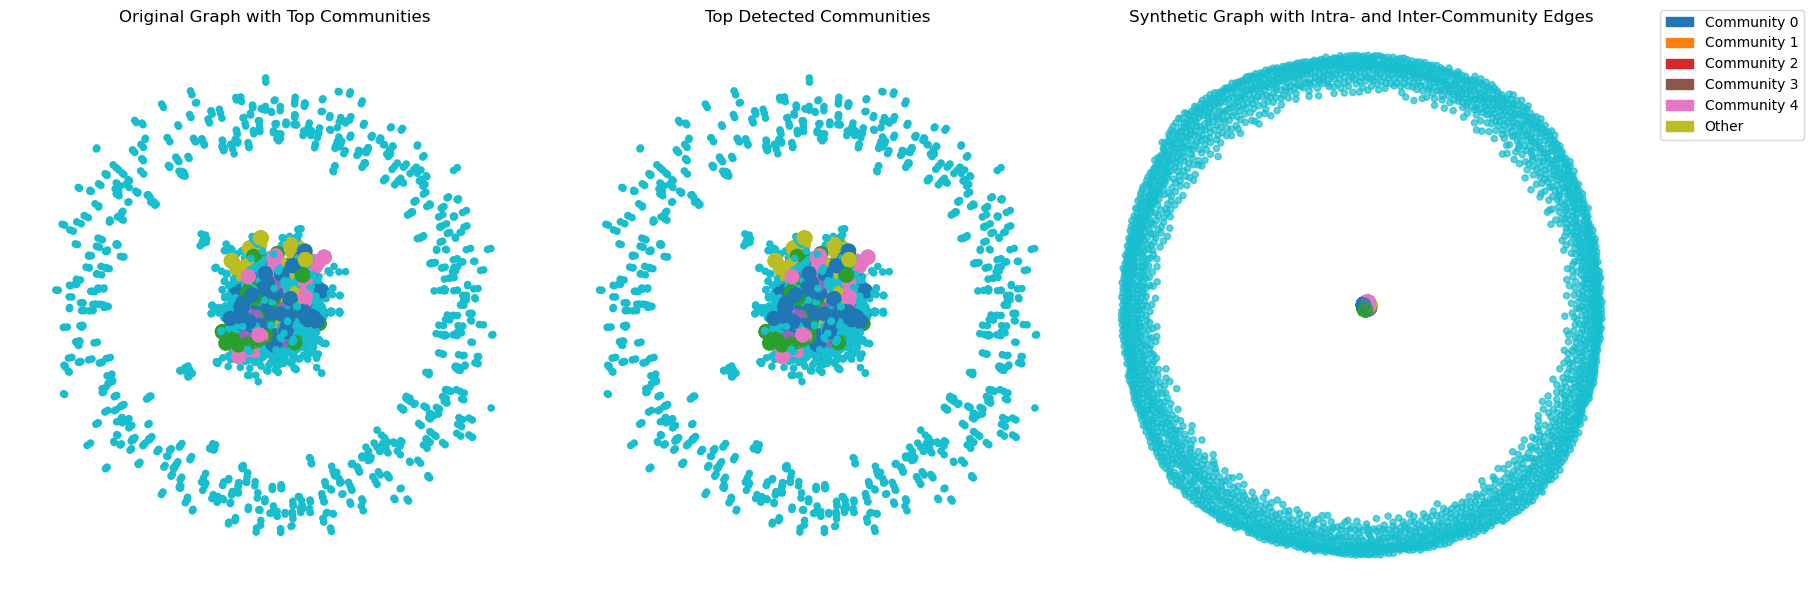

In [ ]:
## Visualization

def create_dcsbm_schematic(original_graph, intra_prob=0.4, inter_prob=0.02, top_k=5):
    """
    Create an improved schematic representation of the Community-Based DCSBM Anonymization process.

    :param original_graph: A NetworkX graph.
    :param intra_prob: Probability of edges within communities.
    :param inter_prob: Probability of edges between communities.
    :param top_k: Number of largest communities to display separately.
    """
    # Community Detection
    communities = list(greedy_modularity_communities(original_graph))
    sorted_communities = sorted(communities, key=len, reverse=True)
    top_communities = sorted_communities[:top_k]
    other_nodes = set(node for community in sorted_communities[top_k:] for node in community)

    # Assign community IDs for top communities
    community_map = {}
    for idx, community in enumerate(top_communities):
        for node in community:
            community_map[node] = idx
    for node in other_nodes:
        community_map[node] = top_k  # Assign remaining nodes to "Other"

    # Colors for top communities and "Other"
    community_colors = [
        community_map[node] for node in original_graph.nodes()
    ]

    #  Synthetic Graph Generation
    synthetic_graph = nx.Graph()
    synthetic_graph.add_nodes_from(original_graph.nodes())

    # Add intra-community edges
    for community in top_communities:
        community_nodes = list(community)
        for i in range(len(community_nodes)):
            for j in range(i + 1, len(community_nodes)):
                if random.random() < intra_prob:
                    synthetic_graph.add_edge(community_nodes[i], community_nodes[j])

    # Add inter-community edges
    for i, community_i in enumerate(top_communities):
        for j, community_j in enumerate(top_communities):
            if i >= j:
                continue
            for node_i in community_i:
                for node_j in community_j:
                    if random.random() < inter_prob:
                        synthetic_graph.add_edge(node_i, node_j)

    # Plot the Schematic
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Adjust node sizes dynamically based on community size
    node_sizes = [
        100 if community_map[node] < top_k else 20 for node in original_graph.nodes()
    ]

    # Original Graph
    pos_original = nx.spring_layout(original_graph, seed=42)
    nx.draw(
        original_graph,
        pos_original,
        node_color=community_colors,
        cmap=plt.cm.tab10,
        node_size=node_sizes,
        ax=axes[0],
        edge_color="lightgray",
    )
    axes[0].set_title("Original Graph with Top Communities")

    # Community Detection
    pos_community = pos_original  # Use the same layout for consistency
    nx.draw(
        original_graph,
        pos_community,
        node_color=community_colors,
        cmap=plt.cm.tab10,
        node_size=node_sizes,
        ax=axes[1],
        edge_color="lightgray",
    )
    axes[1].set_title("Top Detected Communities")

    # Synthetic Graph
    pos_synthetic = nx.spring_layout(synthetic_graph, seed=42)
    nx.draw(
        synthetic_graph,
        pos_synthetic,
        node_color=community_colors,
        cmap=plt.cm.tab10,
        node_size=node_sizes,
        ax=axes[2],
        edge_color="lightgray",
        alpha=0.7,  # Make edges semi-transparent
    )
    axes[2].set_title("Synthetic Graph with Intra- and Inter-Community Edges")

    # Legend
    legend_labels = [f"Community {i}" for i in range(top_k)] + ["Other"]
    legend_patches = [
        Patch(color=plt.cm.tab10(i / (top_k + 1)), label=label)
        for i, label in enumerate(legend_labels)
    ]
    plt.legend(
        handles=legend_patches,
        loc="upper center",
        bbox_to_anchor=(1.2, 1.05),
        ncol=1,
    )

    plt.tight_layout()
    plt.savefig("dcsbm_schematic.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    graph = download_and_preprocess_graph()
    intra_prob = 0.4  # Adjusted to better preserve intra-community structure
    inter_prob = 0.02
    create_dcsbm_schematic(graph, intra_prob=intra_prob, inter_prob=inter_prob, top_k=5)

# cit DBLP

### 1. Using differential privacy

In [ ]:
def load_cit_dblp_graph(file_path):
    """
    Load the cit-DBLP graph from a given file.

    :param file_path: Path to the cit-DBLP.edges file.
    :return: A NetworkX directed graph.
    """
    print("Processing and loading graph from cit-DBLP.edges...")
    edges = []
    with open(file_path, 'r') as f:
        for line in f:
            # Skip comments or header lines starting with '%'
            if line.startswith('%') or line.strip() == "":
                continue
            # Split and validate edge definition
            parts = line.strip().split()
            if len(parts) == 2:  # Ensure it's a valid edge
                edges.append(tuple(map(int, parts)))  # Convert node IDs to integers

    # Create the graph from the processed edge list
    graph = nx.DiGraph()
    graph.add_edges_from(edges)

    print(f"Graph loaded with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")
    return graph


def preprocess_graph(graph):
    print("Starting graph preprocessing...")

    print("Checking for isolated nodes...")
    isolates = list(nx.isolates(graph))
    if isolates:
        print(f"Found {len(isolates)} isolated nodes. Removing them...")
        graph.remove_nodes_from(isolates)

    print("Checking for self-loops...")
    self_loops = list(nx.selfloop_edges(graph))
    if self_loops:
        print(f"Found {len(self_loops)} self-loops. Removing them...")
        graph.remove_edges_from(self_loops)

    print("Normalizing node IDs...")
    mapping = {node: i for i, node in enumerate(sorted(graph.nodes()))}
    graph = nx.relabel_nodes(graph, mapping)

    print("Ensuring graph is undirected...")
    if nx.is_directed(graph):
        graph = graph.to_undirected()
        print("Converted to undirected graph.")
    else:
        print("Graph is already undirected.")

    print(f"Preprocessing complete. Graph now has {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")
    return graph

# Compute graph metrics
def compute_graph_metrics(graph):
    print("Computing Graph Metrics...")
    properties = {
        "Number of Nodes": graph.number_of_nodes(),
        "Number of Edges": graph.number_of_edges(),
        "Density": nx.density(graph),
    }

    connected_components = list(nx.connected_components(graph))
    properties["Number of Connected Components"] = len(connected_components)
    largest_component_size = max(len(component) for component in connected_components) if connected_components else 0
    properties["Size of Largest Connected Component"] = largest_component_size

    print("Calculating centrality measures...")
    degree_centrality = nx.degree_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    properties["Max Degree Centrality"] = max(degree_centrality.values())
    properties["Max Closeness Centrality"] = max(closeness_centrality.values())
    properties["Max Betweenness Centrality"] = max(betweenness_centrality.values())

    properties["Clustering Coefficient"] = nx.average_clustering(graph)

    if nx.is_connected(graph):
        properties["Diameter"] = nx.diameter(graph)
        properties["Average Path Length"] = nx.average_shortest_path_length(graph)
        properties["Triangles"] = sum(nx.triangles(graph).values()) // 3

    print("\n".join([f"{k}: {v}" for k, v in properties.items()]))
    return properties

# Evaluate privacy preservation
def measure_privacy_preservation(original_graph, perturbed_graph):
    print("Measuring privacy preservation...")
    original_edges = set(original_graph.edges())
    perturbed_edges = set(perturbed_graph.edges())
    common_edges = original_edges.intersection(perturbed_edges)
    reidentification_rate = len(common_edges) / len(original_edges) * 100
    print(f"Edge re-identification rate: {reidentification_rate:.2f}%")
    return reidentification_rate

# Evaluate graph anonymization
def evaluate_graph_anonymization(original_graph, anonymization_function, *args, **kwargs):
    print("Applying anonymization...")
    start_time = time.time()
    anonymized_graph = anonymization_function(original_graph, *args, **kwargs)
    anonymization_time = time.time() - start_time
    print(f"Anonymization completed in {anonymization_time:.2f} seconds.")

    print("Evaluating privacy preservation...")
    reidentification_rate = measure_privacy_preservation(original_graph, anonymized_graph)

    print("Evaluating data utility...")
    original_accuracy, anon_accuracy = evaluate_data_utility(original_graph, anonymized_graph)

    print("Evaluating robustness...")
    robustness_score = evaluate_robustness(original_graph, anonymized_graph)

    print("Evaluating structural similarity...")
    similarity_metrics = evaluate_graph_similarity(original_graph, anonymized_graph)

    results = {
        "Anonymization Time": anonymization_time,
        "Re-Identification Rate": reidentification_rate,
        "Original Accuracy": original_accuracy,
        "Anonymized Accuracy": anon_accuracy,
        "Robustness Score": robustness_score,
        **similarity_metrics,
    }

    return results

In [21]:
def add_differential_privacy_to_degrees(graph, epsilon=0.3):
    sensitivity = 1  # Sensitivity of the degree function is 1
    scale = sensitivity / epsilon

    perturbed_graph = nx.Graph()
    perturbed_graph.add_nodes_from(graph.nodes())

    degree_centrality = nx.degree_centrality(graph)
    for node in graph.nodes():
        true_degree = graph.degree[node]
        node_centrality = degree_centrality[node]

        adjusted_scale = scale / (1 + node_centrality)
        noise = np.random.laplace(0, adjusted_scale, 1)[0]
        noisy_degree = max(0, int(true_degree + noise))

        neighbors = list(graph.neighbors(node))
        random.shuffle(neighbors)
        while len(neighbors) < noisy_degree:
            potential_neighbor = random.choice(list(graph.nodes()))
            if node != potential_neighbor and not perturbed_graph.has_edge(node, potential_neighbor):
                perturbed_graph.add_edge(node, potential_neighbor)
                neighbors.append(potential_neighbor)
        while len(neighbors) > noisy_degree:
            neighbor = neighbors.pop()
            if perturbed_graph.has_edge(node, neighbor):
                perturbed_graph.remove_edge(node, neighbor)

    return perturbed_graph


def add_topology_preserving_edges(graph, k=2):
    degree_centrality = nx.degree_centrality(graph)
    for node in graph.nodes():
        if degree_centrality[node] < 0.1:
            for _ in range(k):
                potential_neighbor = random.choice(list(graph.nodes()))
                if node != potential_neighbor and not graph.has_edge(node, potential_neighbor):
                    graph.add_edge(node, potential_neighbor)
    return graph



def anonymize_and_evaluate(graph):
    epsilon = 0.3
    print("Anonymizing graph with differential privacy...")
    perturbed_graph = add_differential_privacy_to_degrees(graph, epsilon)

    print("Adding topology-preserving edges...")
    perturbed_graph = add_topology_preserving_edges(perturbed_graph, k=2)

    results = evaluate_graph_anonymization(graph, add_differential_privacy_to_degrees, epsilon=epsilon)
    return results


# Main workflow
file_path = "cit-DBLP.edges"
original_graph = load_cit_dblp_graph(file_path)
preprocessed_graph = preprocess_graph(original_graph)

print("Performing anonymization and evaluation...")
results = anonymize_and_evaluate(preprocessed_graph)

print("\nAnonymization Results:")
for key, value in results.items():
    print(f"{key}: {value}")

Processing and loading graph from cit-DBLP.edges...
Graph loaded with 12591 nodes and 49743 edges.
Starting graph preprocessing...
Checking for isolated nodes...
Checking for self-loops...
Found 15 self-loops. Removing them...
Normalizing node IDs...
Ensuring graph is undirected...
Converted to undirected graph.
Preprocessing complete. Graph now has 12591 nodes and 49620 edges.
Performing anonymization and evaluation...
Anonymizing graph with differential privacy...
Adding topology-preserving edges...
Applying anonymization...
Anonymization completed in 0.85 seconds.
Evaluating privacy preservation...
Measuring privacy preservation...
Edge re-identification rate: 0.01%
Evaluating data utility...
Evaluating data utility...
Original accuracy: 1.00
Perturbed accuracy: 0.68
Evaluating robustness...
Evaluating robustness...
Robustness (degree distribution similarity): 0.36
Evaluating structural similarity...

Anonymization Results:
Anonymization Time: 0.8530013561248779
Re-Identification Ra

### 2. Using Hybrid Anonymization

In [ ]:
def add_differential_privacy_to_degrees(graph, epsilon=0.3):
    """
    Add differential privacy to the node degrees of a graph with topology-aware noise.

    :param graph: A NetworkX graph.
    :param epsilon: Privacy budget, a smaller epsilon means more privacy.
    :return: A perturbed graph with noisy degrees and edges.
    """
    sensitivity = 1  # Sensitivity of the degree function is 1
    scale = sensitivity / epsilon

    # Create a copy of the graph to perturb
    perturbed_graph = nx.Graph()
    perturbed_graph.add_nodes_from(graph.nodes())

    # Topology-aware noise: Adjust noise based on centrality metrics
    degree_centrality = nx.degree_centrality(graph)
    for node in graph.nodes():
        true_degree = graph.degree[node]
        node_centrality = degree_centrality[node]

        # Scale noise inversely with centrality to obfuscate high-centrality nodes less
        adjusted_scale = scale / (1 + node_centrality)
        noise = np.random.laplace(0, adjusted_scale, 1)[0]  # Generate Laplace noise
        noisy_degree = max(0, int(true_degree + noise))  # Ensure non-negative degree

        # Add or remove edges to achieve noisy degree
        neighbors = list(graph.neighbors(node))
        random.shuffle(neighbors)
        # Add edges
        while len(neighbors) < noisy_degree:
            potential_neighbor = random.choice(list(graph.nodes()))
            if node != potential_neighbor and not perturbed_graph.has_edge(node, potential_neighbor):
                perturbed_graph.add_edge(node, potential_neighbor)
                neighbors.append(potential_neighbor)
        # Remove excess edges if noisy degree is less than the true degree
        while len(neighbors) > noisy_degree:
            neighbor = neighbors.pop()
            if perturbed_graph.has_edge(node, neighbor):
                perturbed_graph.remove_edge(node, neighbor)

    return perturbed_graph

def add_topology_preserving_edges(graph, k=2):
    """
    Add edges to preserve connectivity while obfuscating structure selectively.

    :param graph: A NetworkX graph.
    :param k: Number of random edges to add for each low-centrality node.
    :return: A graph with additional random edges.
    """
    degree_centrality = nx.degree_centrality(graph)
    for node in graph.nodes():
        if degree_centrality[node] < 0.1:  # Focus on low-centrality nodes
            for _ in range(k):
                potential_neighbor = random.choice(list(graph.nodes()))
                if node != potential_neighbor and not graph.has_edge(node, potential_neighbor):
                    graph.add_edge(node, potential_neighbor)

    return graph

def hybrid_anonymization(graph, epsilon=0.3):
    """
    Combine differential privacy with edge-swapping for hybrid anonymization.

    :param graph: A NetworkX graph.
    :param epsilon: Privacy budget for differential privacy.
    :return: An anonymized graph.
    """
    perturbed_graph = add_differential_privacy_to_degrees(graph, epsilon)

    # Edge-swapping to preserve degree distributions while obfuscating structure
    edges = list(perturbed_graph.edges())
    random.shuffle(edges)
    num_swaps = len(edges) // 10  # Swap 10% of edges

    for _ in range(num_swaps):
        edge1 = random.choice(edges)
        edge2 = random.choice(edges)
        u1, v1 = edge1
        u2, v2 = edge2

        # Ensure no self-loops or duplicate edges are created
        if len(set([u1, v1, u2, v2])) == 4:
            if perturbed_graph.has_edge(u1, v1) and perturbed_graph.has_edge(u2, v2):
                perturbed_graph.remove_edge(u1, v1)
                perturbed_graph.remove_edge(u2, v2)
                perturbed_graph.add_edge(u1, u2)
                perturbed_graph.add_edge(v1, v2)

    return perturbed_graph

def extract_robust_features(graph):
    """
    Extract robust features from the graph for utility evaluation.

    :param graph: A NetworkX graph.
    :return: A dictionary of features.
    """
    features = {}
    features['Degree'] = dict(graph.degree())
    features['Clustering Coefficient'] = nx.clustering(graph)
    features['Betweenness Centrality'] = nx.betweenness_centrality(graph)
    features['Closeness Centrality'] = nx.closeness_centrality(graph)
    features['Triangles'] = nx.triangles(graph)
    return features

def anonymize_and_evaluate(graph):
    epsilon = 0.3  # Moderate privacy budget for better utility-privacy balance

    # Apply hybrid anonymization to the graph
    print("Applying hybrid anonymization...")
    anonymized_graph = hybrid_anonymization(graph, epsilon)

    # Extract robust features for evaluation
    print("Extracting robust features for utility evaluation...")
    original_features = extract_robust_features(graph)
    anonymized_features = extract_robust_features(anonymized_graph)

    # Evaluate the anonymized graph
    results = evaluate_graph_anonymization(graph, hybrid_anonymization, epsilon=epsilon)

    # Include feature similarity in results
    feature_similarity = {
        feature: np.corrcoef(list(original_features[feature].values()),
                             list(anonymized_features[feature].values()))[0, 1]
        for feature in original_features
    }
    results['Feature Similarity'] = feature_similarity

    return results

# Perform anonymization and evaluation
results = anonymize_and_evaluate(preprocessed_graph)

# Print results
print("\nAnonymization Results:")
for key, value in results.items():
    if key == 'Feature Similarity':
        print(f"{key}:")
        for feature, similarity in value.items():
            print(f"  {feature}: {similarity:.4f}")
    else:
        print(f"{key}: {value}")


Applying hybrid anonymization...
Extracting robust features for utility evaluation...
Applying anonymization...
Anonymization completed in 0.81 seconds.
Evaluating privacy preservation...
Measuring privacy preservation...
Edge re-identification rate: 0.01%
Evaluating data utility...
Evaluating data utility...
Original accuracy: 1.00
Perturbed accuracy: 0.68
Evaluating robustness...
Evaluating robustness...
Robustness (degree distribution similarity): 0.35
Evaluating structural similarity...

Anonymization Results:
Anonymization Time: 0.8122050762176514
Re-Identification Rate: 0.014107214832728738
Original Accuracy: 1.0
Anonymized Accuracy: 0.6823921848939719
Robustness Score: 0.3532849657396211
Degree Distribution Correlation: -0.010568111806346002
Clustering Coefficient Correlation: -0.00572007727129494
Triangles Similarity: -0.006278665608657525
Modularity Difference: 0.08175826657735497
Feature Similarity:
  Degree: 0.0033
  Clustering Coefficient: -0.0065
  Betweenness Centrality: 

### 3. Synthetic Graph

In [ ]:
# Helper Functions
def generate_synthetic_graph_from_degree_distribution(original_graph):
    """
    Generate a synthetic graph with a matching degree distribution using the Configuration Model.
    """
    degree_sequence = [degree for _, degree in original_graph.degree()]
    synthetic_graph = nx.configuration_model(degree_sequence)
    synthetic_graph = nx.Graph(synthetic_graph)  # Convert to simple graph
    synthetic_graph.remove_edges_from(nx.selfloop_edges(synthetic_graph))
    return synthetic_graph

def add_differential_privacy_to_degrees(graph, epsilon=0.3):
    """
    Add differential privacy to the node degrees of a graph with topology-aware noise.
    """
    sensitivity = 1  # Sensitivity of the degree function is 1
    scale = sensitivity / epsilon

    perturbed_graph = nx.Graph()
    perturbed_graph.add_nodes_from(graph.nodes())
    degree_centrality = nx.degree_centrality(graph)

    for node in graph.nodes():
        true_degree = graph.degree[node]
        node_centrality = degree_centrality[node]
        adjusted_scale = scale / (1 + node_centrality)
        noise = np.random.laplace(0, adjusted_scale, 1)[0]
        noisy_degree = max(0, int(true_degree + noise))

        neighbors = list(graph.neighbors(node))
        random.shuffle(neighbors)

        while len(neighbors) < noisy_degree:
            potential_neighbor = random.choice(list(graph.nodes()))
            if node != potential_neighbor and not perturbed_graph.has_edge(node, potential_neighbor):
                perturbed_graph.add_edge(node, potential_neighbor)
                neighbors.append(potential_neighbor)

        while len(neighbors) > noisy_degree:
            neighbor = neighbors.pop()
            if perturbed_graph.has_edge(node, neighbor):
                perturbed_graph.remove_edge(node, neighbor)

    return perturbed_graph

def hybrid_anonymization(graph, epsilon=0.3):
    """
    Combine differential privacy with edge-swapping for hybrid anonymization.
    """
    perturbed_graph = add_differential_privacy_to_degrees(graph, epsilon)
    edges = list(perturbed_graph.edges())
    random.shuffle(edges)
    num_swaps = len(edges) // 10

    for _ in range(num_swaps):
        edge1 = random.choice(edges)
        edge2 = random.choice(edges)
        u1, v1 = edge1
        u2, v2 = edge2

        if len(set([u1, v1, u2, v2])) == 4:
            if perturbed_graph.has_edge(u1, v1) and perturbed_graph.has_edge(u2, v2):
                perturbed_graph.remove_edge(u1, v1)
                perturbed_graph.remove_edge(u2, v2)
                perturbed_graph.add_edge(u1, u2)
                perturbed_graph.add_edge(v1, v2)

    return perturbed_graph

def anonymize_and_evaluate_with_synthetic_graph(original_graph, epsilon=0.3):
    """
    Main workflow to anonymize using synthetic graph and evaluate the results.
    """
    print("Generating synthetic graph...")
    synthetic_graph = generate_synthetic_graph_from_degree_distribution(original_graph)

    print("Applying differential privacy to synthetic graph...")
    start_time = time.time()
    anonymized_graph = hybrid_anonymization(synthetic_graph, epsilon)
    anonymization_time = time.time() - start_time
    print(f"Anonymization completed in {anonymization_time:.2f} seconds.")

    print("\nEvaluating graph anonymization...")
    results = evaluate_graph_anonymization(original_graph, hybrid_anonymization, epsilon=epsilon)
    results["Anonymization Time"] = anonymization_time

    return anonymized_graph, results


print("\nApplying hybrid anonymization with synthetic graph...")
anonymized_graph, results = anonymize_and_evaluate_with_synthetic_graph(preprocessed_graph, epsilon=0.3)

print("\nFinal Evaluation Results:")
for key, value in results.items():
    print(f"{key}: {value}")


Applying hybrid anonymization with synthetic graph...
Generating synthetic graph...
Applying differential privacy to synthetic graph...
Anonymization completed in 0.97 seconds.

Evaluating graph anonymization...
Applying anonymization...
Anonymization completed in 0.87 seconds.
Evaluating privacy preservation...
Measuring privacy preservation...
Edge re-identification rate: 0.02%
Evaluating data utility...
Evaluating data utility...
Original accuracy: 1.00
Perturbed accuracy: 0.68
Evaluating robustness...
Evaluating robustness...
Robustness (degree distribution similarity): 0.37
Evaluating structural similarity...

Final Evaluation Results:
Anonymization Time: 0.9717140197753906
Re-Identification Rate: 0.016122531237404272
Original Accuracy: 1.0
Anonymized Accuracy: 0.6790564689063617
Robustness Score: 0.37271261588069327
Degree Distribution Correlation: 0.006317794955388609
Clustering Coefficient Correlation: 0.0008686952403419912
Triangles Similarity: -0.0033170812675967737
Modulari

### 4. Synthetic Graph with DCSBM

In [ ]:
def generate_synthetic_graph_dcsbm(original_graph, intra_prob=0.3, inter_prob=0.01):
    """
    Generate a synthetic graph using Degree-Corrected Stochastic Block Model (DCSBM).

    :param original_graph: A NetworkX graph.
    :param intra_prob: Probability of edges within communities.
    :param inter_prob: Probability of edges between communities.
    :return: A synthetic graph preserving community structures and degree distribution.
    """
    # Detect communities using modularity-based method
    communities = list(greedy_modularity_communities(original_graph))
    community_map = {node: i for i, community in enumerate(communities) for node in community}

    # Group nodes by community
    community_sizes = [len(c) for c in communities]

    synthetic_graph = nx.Graph()
    synthetic_graph.add_nodes_from(original_graph.nodes())

    # Add intra-community edges
    for community in communities:
        community_nodes = list(community)
        for i in range(len(community_nodes)):
            for j in range(i + 1, len(community_nodes)):
                if np.random.random() < intra_prob:
                    synthetic_graph.add_edge(community_nodes[i], community_nodes[j])

    # Add inter-community edges
    for i, community_i in enumerate(communities):
        for j, community_j in enumerate(communities):
            if i >= j:
                continue
            for node_i in community_i:
                for node_j in community_j:
                    if np.random.random() < inter_prob:
                        synthetic_graph.add_edge(node_i, node_j)

    return synthetic_graph

def add_differential_privacy_to_degrees(graph, epsilon=0.3):
    """
    Add differential privacy to the node degrees of a graph with topology-aware noise.

    :param graph: A NetworkX graph.
    :param epsilon: Privacy budget, a smaller epsilon means more privacy.
    :return: A perturbed graph with noisy degrees and edges.
    """
    sensitivity = 1  # Sensitivity of the degree function is 1
    scale = sensitivity / epsilon

    perturbed_graph = nx.Graph()
    perturbed_graph.add_nodes_from(graph.nodes())

    degree_centrality = nx.degree_centrality(graph)
    for node in graph.nodes():
        true_degree = graph.degree[node]
        node_centrality = degree_centrality[node]

        adjusted_scale = scale / (1 + node_centrality)
        noise = np.random.laplace(0, adjusted_scale, 1)[0]
        noisy_degree = max(0, int(true_degree + noise))

        neighbors = list(graph.neighbors(node))
        random.shuffle(neighbors)
        while len(neighbors) < noisy_degree:
            potential_neighbor = random.choice(list(graph.nodes()))
            if node != potential_neighbor and not perturbed_graph.has_edge(node, potential_neighbor):
                perturbed_graph.add_edge(node, potential_neighbor)
                neighbors.append(potential_neighbor)
        while len(neighbors) > noisy_degree:
            neighbor = neighbors.pop()
            if perturbed_graph.has_edge(node, neighbor):
                perturbed_graph.remove_edge(node, neighbor)

    return perturbed_graph

def post_process_graph(anonymized_graph, original_graph):
    """
    Refine the anonymized graph to improve its similarity to the original graph.

    :param anonymized_graph: The anonymized NetworkX graph.
    :param original_graph: The original NetworkX graph.
    :return: A refined anonymized graph.
    """
    refined_graph = anonymized_graph.copy()

    original_clustering = nx.clustering(original_graph)
    anonymized_clustering = nx.clustering(refined_graph)

    # Adjust clustering coefficients
    for node in refined_graph.nodes():
        if anonymized_clustering[node] < original_clustering[node]:
            potential_neighbors = list(set(refined_graph.nodes()) - set(refined_graph.neighbors(node)) - {node})
            if potential_neighbors:
                neighbor_to_add = random.choice(potential_neighbors)
                refined_graph.add_edge(node, neighbor_to_add)
        elif anonymized_clustering[node] > original_clustering[node]:
            neighbors = list(refined_graph.neighbors(node))
            if neighbors:
                neighbor_to_remove = random.choice(neighbors)
                refined_graph.remove_edge(node, neighbor_to_remove)

    return refined_graph

def anonymize_and_evaluate_with_refinements(original_graph, epsilon_values, intra_prob=0.3, inter_prob=0.01):
    results = {}
    for epsilon in epsilon_values:
        print(f"Testing with epsilon = {epsilon}...")

        # Generate synthetic graph
        print("Generating synthetic graph using DCSBM...")
        synthetic_graph = generate_synthetic_graph_dcsbm(original_graph, intra_prob=intra_prob, inter_prob=inter_prob)

        # Apply differential privacy and measure time
        print("Applying differential privacy...")
        start_time = time.time()
        perturbed_graph = add_differential_privacy_to_degrees(synthetic_graph, epsilon)
        anonymization_time = time.time() - start_time
        print(f"Anonymization Time: {anonymization_time:.2f} seconds")

        # Post-process the graph
        print("Post-processing the anonymized graph...")
        refined_graph = post_process_graph(perturbed_graph, original_graph)

        # Evaluate metrics
        print("Evaluating similarity and additional metrics...")

        # Measure degree distribution correlation, clustering coefficient, and modularity
        degree_corr = np.corrcoef(
            [d for _, d in original_graph.degree()],
            [d for _, d in refined_graph.degree()]
        )[0, 1]
        clustering_corr = np.corrcoef(
            list(nx.clustering(original_graph).values()),
            list(nx.clustering(refined_graph).values())
        )[0, 1]
        modularity_diff = abs(
            modularity(original_graph, greedy_modularity_communities(original_graph)) -
            modularity(refined_graph, greedy_modularity_communities(refined_graph))
        )

        # Measure triangles similarity
        triangles_similarity = np.corrcoef(
            list(nx.triangles(original_graph).values()),
            list(nx.triangles(refined_graph).values())
        )[0, 1]

        # Re-identification rate
        original_edges = set(original_graph.edges())
        refined_edges = set(refined_graph.edges())
        common_edges = original_edges.intersection(refined_edges)
        re_identification_rate = len(common_edges) / len(original_edges) * 100

        # Original and anonymized accuracy
        original_accuracy, anonymized_accuracy = evaluate_data_utility(original_graph, refined_graph)

        # Robustness score
        robustness_score = evaluate_robustness(original_graph, refined_graph)

        # Consolidate results
        results[epsilon] = {
            "Anonymization Time": anonymization_time,
            "Re-Identification Rate": re_identification_rate,
            "Original Accuracy": original_accuracy,
            "Anonymized Accuracy": anonymized_accuracy,
            "Robustness Score": robustness_score,
            "Degree Distribution Correlation": degree_corr,
            "Clustering Coefficient Correlation": clustering_corr,
            "Triangles Similarity": triangles_similarity,
            "Modularity Difference": modularity_diff
        }

    return results


epsilon_values = [0.1, 0.3, 0.5, 0.7, 1.0]  # Test different epsilon values
intra_prob = 0.4  # Adjusted to better preserve intra-community structure
inter_prob = 0.02  # Adjusted to better preserve inter-community structure

results = anonymize_and_evaluate_with_refinements(graph, epsilon_values, intra_prob=intra_prob, inter_prob=inter_prob)

print("\nAnonymization Results:")
for epsilon, metrics in results.items():
    print(f"Epsilon: {epsilon}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Testing with epsilon = 0.1...
Generating synthetic graph using DCSBM...
Applying differential privacy...
Anonymization Time: 0.68 seconds
Post-processing the anonymized graph...
Evaluating similarity and additional metrics...
Evaluating data utility...
Original accuracy: 1.00
Perturbed accuracy: 0.41
Evaluating robustness...
Robustness (degree distribution similarity): 0.13
Testing with epsilon = 0.3...
Generating synthetic graph using DCSBM...
Applying differential privacy...
Anonymization Time: 0.34 seconds
Post-processing the anonymized graph...
Evaluating similarity and additional metrics...
Evaluating data utility...
Original accuracy: 1.00
Perturbed accuracy: 0.65
Evaluating robustness...
Robustness (degree distribution similarity): 0.63
Testing with epsilon = 0.5...
Generating synthetic graph using DCSBM...
Applying differential privacy...
Anonymization Time: 0.26 seconds
Post-processing the anonymized graph...
Evaluating similarity and additional metrics...
Evaluating data util

/Users/devikarajasekar/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/devikarajasekar/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Evaluating data utility...
Original accuracy: 1.00
Perturbed accuracy: 0.73
Evaluating robustness...
Robustness (degree distribution similarity): 0.42
Testing with epsilon = 1.0...
Generating synthetic graph using DCSBM...
Applying differential privacy...
Anonymization Time: 0.22 seconds
Post-processing the anonymized graph...
Evaluating similarity and additional metrics...


/Users/devikarajasekar/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/devikarajasekar/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Evaluating data utility...
Original accuracy: 1.00
Perturbed accuracy: 0.73
Evaluating robustness...
Robustness (degree distribution similarity): 0.36

Anonymization Results:
Epsilon: 0.1
  Anonymization Time: 0.6792
  Re-Identification Rate: 0.1588
  Original Accuracy: 1.0000
  Anonymized Accuracy: 0.4142
  Robustness Score: 0.1295
  Degree Distribution Correlation: 0.0159
  Clustering Coefficient Correlation: -0.0136
  Triangles Similarity: -0.0022
  Modularity Difference: 0.5527
Epsilon: 0.3
  Anonymization Time: 0.3421
  Re-Identification Rate: 0.0552
  Original Accuracy: 1.0000
  Anonymized Accuracy: 0.6482
  Robustness Score: 0.6328
  Degree Distribution Correlation: 0.0431
  Clustering Coefficient Correlation: -0.0072
  Triangles Similarity: 0.0116
  Modularity Difference: 0.3209
Epsilon: 0.5
  Anonymization Time: 0.2631
  Re-Identification Rate: 0.0759
  Original Accuracy: 1.0000
  Anonymized Accuracy: 0.7043
  Robustness Score: 0.5289
  Degree Distribution Correlation: 0.0732


# enron-large

In [27]:
def download_and_load_email_enron_graph():
    url = "https://snap.stanford.edu/data/email-Enron.txt.gz"
    file_name = "email-Enron.txt.gz"

    if not os.path.exists(file_name):
        print("Downloading dataset...")
        urllib.request.urlretrieve(url, file_name)

    print("Processing and loading graph...")
    
    edges = []
    with gzip.open(file_name, 'rt') as f:
        for line in f:
            # Skip comments or lines that do not represent edges
            if line.startswith('#') or line.strip() == "":
                continue
            # Split and validate edge definition
            parts = line.strip().split()
            if len(parts) == 2:  # Ensure it's a valid edge
                edges.append(tuple(map(int, parts)))  # Convert node IDs to integers
    
    # Create the graph from the processed edge list
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    
    print(f"Graph loaded with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")
    return graph

### 1. Using differential privacy

In [ ]:
def add_differential_privacy_to_degrees(graph, epsilon=0.3):
    """
    Add differential privacy to the node degrees of a graph with topology-aware noise.

    :param graph: A NetworkX graph.
    :param epsilon: Privacy budget, a smaller epsilon means more privacy.
    :return: A perturbed graph with noisy degrees and edges.
    """
    sensitivity = 1  # Sensitivity of the degree function is 1
    scale = sensitivity / epsilon

    # Create a copy of the graph to perturb
    perturbed_graph = nx.Graph()
    perturbed_graph.add_nodes_from(graph.nodes())

    # Topology-aware noise: Adjust noise based on centrality metrics
    degree_centrality = nx.degree_centrality(graph)
    for node in graph.nodes():
        true_degree = graph.degree[node]
        node_centrality = degree_centrality[node]

        # Scale noise inversely with centrality to obfuscate high-centrality nodes less
        adjusted_scale = scale / (1 + node_centrality)
        noise = np.random.laplace(0, adjusted_scale, 1)[0]  # Generate Laplace noise
        noisy_degree = max(0, int(true_degree + noise))  # Ensure non-negative degree

        # Add or remove edges to achieve noisy degree
        neighbors = list(graph.neighbors(node))
        random.shuffle(neighbors)
        # Add edges
        while len(neighbors) < noisy_degree:
            potential_neighbor = random.choice(list(graph.nodes()))
            if node != potential_neighbor and not perturbed_graph.has_edge(node, potential_neighbor):
                perturbed_graph.add_edge(node, potential_neighbor)
                neighbors.append(potential_neighbor)
        # Remove excess edges if noisy degree is less than the true degree
        while len(neighbors) > noisy_degree:
            neighbor = neighbors.pop()
            if perturbed_graph.has_edge(node, neighbor):
                perturbed_graph.remove_edge(node, neighbor)

    return perturbed_graph

def add_topology_preserving_edges(graph, k=2):
    """
    Add edges to preserve connectivity while obfuscating structure selectively.

    :param graph: A NetworkX graph.
    :param k: Number of random edges to add for each low-centrality node.
    :return: A graph with additional random edges.
    """
    degree_centrality = nx.degree_centrality(graph)
    for node in graph.nodes():
        if degree_centrality[node] < 0.1:  # Focus on low-centrality nodes
            for _ in range(k):
                potential_neighbor = random.choice(list(graph.nodes()))
                if node != potential_neighbor and not graph.has_edge(node, potential_neighbor):
                    graph.add_edge(node, potential_neighbor)

    return graph

def anonymize_and_evaluate(graph):
    epsilon = 0.3  # Moderate privacy budget for better utility-privacy balance

    # Apply differential privacy to the graph
    print("Anonymizing graph with differential privacy...")
    perturbed_graph = add_differential_privacy_to_degrees(graph, epsilon)

    # Add topology-preserving edges
    print("Adding topology-preserving edges...")
    perturbed_graph = add_topology_preserving_edges(perturbed_graph, k=2)

    # Evaluate the anonymized graph
    results = evaluate_graph_anonymization(graph, add_differential_privacy_to_degrees, epsilon=epsilon)
    return results

# Download and preprocess the graph
graph = download_and_load_email_enron_graph()
preprocessed_graph = preprocess_graph(graph)

# Perform anonymization and evaluation
results = anonymize_and_evaluate(preprocessed_graph)

# Print results
print("\nAnonymization Results:")
for key, value in results.items():
    print(f"{key}: {value}")


Processing and loading graph...
Graph loaded with 36692 nodes and 367662 edges.
Starting graph preprocessing...
Checking for isolated nodes...
Checking for self-loops...
Normalizing node IDs...
Ensuring graph is undirected...
Converted to undirected graph.
Preprocessing complete. Graph now has 36692 nodes and 183831 edges.
Anonymizing graph with differential privacy...
Adding topology-preserving edges...
Applying anonymization...
Anonymization completed in 7.06 seconds.
Evaluating privacy preservation...
Measuring privacy preservation...
Edge re-identification rate: 0.01%
Evaluating data utility...
Evaluating data utility...
Original accuracy: 1.00
Perturbed accuracy: 0.82
Evaluating robustness...
Evaluating robustness...
Robustness (degree distribution similarity): 0.28
Evaluating structural similarity...

Anonymization Results:
Anonymization Time: 7.059906721115112
Re-Identification Rate: 0.010879557854768782
Original Accuracy: 1.0
Anonymized Accuracy: 0.8210236563828628
Robustness S

### 2. Using Hybrid Anonymization

In [ ]:
def add_differential_privacy_to_degrees(graph, epsilon=0.3):
    """
    Add differential privacy to the node degrees of a graph with topology-aware noise.

    :param graph: A NetworkX graph.
    :param epsilon: Privacy budget, a smaller epsilon means more privacy.
    :return: A perturbed graph with noisy degrees and edges.
    """
    sensitivity = 1  # Sensitivity of the degree function is 1
    scale = sensitivity / epsilon

    # Create a copy of the graph to perturb
    perturbed_graph = nx.Graph()
    perturbed_graph.add_nodes_from(graph.nodes())

    # Topology-aware noise: Adjust noise based on centrality metrics
    degree_centrality = nx.degree_centrality(graph)
    for node in graph.nodes():
        true_degree = graph.degree[node]
        node_centrality = degree_centrality[node]

        # Scale noise inversely with centrality to obfuscate high-centrality nodes less
        adjusted_scale = scale / (1 + node_centrality)
        noise = np.random.laplace(0, adjusted_scale, 1)[0]  # Generate Laplace noise
        noisy_degree = max(0, int(true_degree + noise))  # Ensure non-negative degree

        # Add or remove edges to achieve noisy degree
        neighbors = list(graph.neighbors(node))
        random.shuffle(neighbors)
        # Add edges
        while len(neighbors) < noisy_degree:
            potential_neighbor = random.choice(list(graph.nodes()))
            if node != potential_neighbor and not perturbed_graph.has_edge(node, potential_neighbor):
                perturbed_graph.add_edge(node, potential_neighbor)
                neighbors.append(potential_neighbor)
        # Remove excess edges if noisy degree is less than the true degree
        while len(neighbors) > noisy_degree:
            neighbor = neighbors.pop()
            if perturbed_graph.has_edge(node, neighbor):
                perturbed_graph.remove_edge(node, neighbor)

    return perturbed_graph

def add_topology_preserving_edges(graph, k=2):
    """
    Add edges to preserve connectivity while obfuscating structure selectively.

    :param graph: A NetworkX graph.
    :param k: Number of random edges to add for each low-centrality node.
    :return: A graph with additional random edges.
    """
    degree_centrality = nx.degree_centrality(graph)
    for node in graph.nodes():
        if degree_centrality[node] < 0.1:  # Focus on low-centrality nodes
            for _ in range(k):
                potential_neighbor = random.choice(list(graph.nodes()))
                if node != potential_neighbor and not graph.has_edge(node, potential_neighbor):
                    graph.add_edge(node, potential_neighbor)

    return graph

def hybrid_anonymization(graph, epsilon=0.3):
    """
    Combine differential privacy with edge-swapping for hybrid anonymization.

    :param graph: A NetworkX graph.
    :param epsilon: Privacy budget for differential privacy.
    :return: An anonymized graph.
    """
    perturbed_graph = add_differential_privacy_to_degrees(graph, epsilon)

    # Edge-swapping to preserve degree distributions while obfuscating structure
    edges = list(perturbed_graph.edges())
    random.shuffle(edges)
    num_swaps = len(edges) // 10  # Swap 10% of edges

    for _ in range(num_swaps):
        edge1 = random.choice(edges)
        edge2 = random.choice(edges)
        u1, v1 = edge1
        u2, v2 = edge2

        # Ensure no self-loops or duplicate edges are created
        if len(set([u1, v1, u2, v2])) == 4:
            if perturbed_graph.has_edge(u1, v1) and perturbed_graph.has_edge(u2, v2):
                perturbed_graph.remove_edge(u1, v1)
                perturbed_graph.remove_edge(u2, v2)
                perturbed_graph.add_edge(u1, u2)
                perturbed_graph.add_edge(v1, v2)

    return perturbed_graph

def extract_robust_features(graph):
    """
    Extract robust features from the graph for utility evaluation.

    :param graph: A NetworkX graph.
    :return: A dictionary of features.
    """
    features = {}
    features['Degree'] = dict(graph.degree())
    features['Clustering Coefficient'] = nx.clustering(graph)
    features['Betweenness Centrality'] = nx.betweenness_centrality(graph)
    features['Closeness Centrality'] = nx.closeness_centrality(graph)
    features['Triangles'] = nx.triangles(graph)
    return features

def anonymize_and_evaluate(graph):
    epsilon = 0.3  # Moderate privacy budget for better utility-privacy balance

    # Apply hybrid anonymization to the graph
    print("Applying hybrid anonymization...")
    anonymized_graph = hybrid_anonymization(graph, epsilon)

    # Extract robust features for evaluation
    print("Extracting robust features for utility evaluation...")
    original_features = extract_robust_features(graph)
    anonymized_features = extract_robust_features(anonymized_graph)

    # Evaluate the anonymized graph
    results = evaluate_graph_anonymization(graph, hybrid_anonymization, epsilon=epsilon)

    # Include feature similarity in results
    feature_similarity = {
        feature: np.corrcoef(list(original_features[feature].values()),
                             list(anonymized_features[feature].values()))[0, 1]
        for feature in original_features
    }
    results['Feature Similarity'] = feature_similarity

    return results

# Perform anonymization and evaluation
results = anonymize_and_evaluate(preprocessed_graph)

# Print results
print("\nAnonymization Results:")
for key, value in results.items():
    if key == 'Feature Similarity':
        print(f"{key}:")
        for feature, similarity in value.items():
            print(f"  {feature}: {similarity:.4f}")
    else:
        print(f"{key}: {value}")


Applying hybrid anonymization...
Extracting robust features for utility evaluation...
Applying anonymization...
Anonymization completed in 6.95 seconds.
Evaluating privacy preservation...
Measuring privacy preservation...
Edge re-identification rate: 0.01%
Evaluating data utility...
Evaluating data utility...
Original accuracy: 1.00
Perturbed accuracy: 0.82
Evaluating robustness...
Evaluating robustness...
Robustness (degree distribution similarity): 0.28
Evaluating structural similarity...

Anonymization Results:
Anonymization Time: 6.952798843383789
Re-Identification Rate: 0.005439778927384391
Original Accuracy: 1.0
Anonymized Accuracy: 0.8221955739670773
Robustness Score: 0.2812800887771921
Degree Distribution Correlation: -0.005795020651793278
Clustering Coefficient Correlation: 0.006801445024595412
Triangles Similarity: -0.0017742272541537436
Modularity Difference: 0.09313630525483396
Feature Similarity:
  Degree: -0.0043
  Clustering Coefficient: 0.0021
  Betweenness Centrality: 

### 3. Synthetic Graph

In [ ]:
# Helper Functions
def generate_synthetic_graph_from_degree_distribution(original_graph):
    """
    Generate a synthetic graph with a matching degree distribution using the Configuration Model.
    """
    degree_sequence = [degree for _, degree in original_graph.degree()]
    synthetic_graph = nx.configuration_model(degree_sequence)
    synthetic_graph = nx.Graph(synthetic_graph)  # Convert to simple graph
    synthetic_graph.remove_edges_from(nx.selfloop_edges(synthetic_graph))
    return synthetic_graph

def add_differential_privacy_to_degrees(graph, epsilon=0.3):
    """
    Add differential privacy to the node degrees of a graph with topology-aware noise.
    """
    sensitivity = 1  # Sensitivity of the degree function is 1
    scale = sensitivity / epsilon

    perturbed_graph = nx.Graph()
    perturbed_graph.add_nodes_from(graph.nodes())
    degree_centrality = nx.degree_centrality(graph)

    for node in graph.nodes():
        true_degree = graph.degree[node]
        node_centrality = degree_centrality[node]
        adjusted_scale = scale / (1 + node_centrality)
        noise = np.random.laplace(0, adjusted_scale, 1)[0]
        noisy_degree = max(0, int(true_degree + noise))

        neighbors = list(graph.neighbors(node))
        random.shuffle(neighbors)

        while len(neighbors) < noisy_degree:
            potential_neighbor = random.choice(list(graph.nodes()))
            if node != potential_neighbor and not perturbed_graph.has_edge(node, potential_neighbor):
                perturbed_graph.add_edge(node, potential_neighbor)
                neighbors.append(potential_neighbor)

        while len(neighbors) > noisy_degree:
            neighbor = neighbors.pop()
            if perturbed_graph.has_edge(node, neighbor):
                perturbed_graph.remove_edge(node, neighbor)

    return perturbed_graph

def hybrid_anonymization(graph, epsilon=0.3):
    """
    Combine differential privacy with edge-swapping for hybrid anonymization.
    """
    perturbed_graph = add_differential_privacy_to_degrees(graph, epsilon)
    edges = list(perturbed_graph.edges())
    random.shuffle(edges)
    num_swaps = len(edges) // 10

    for _ in range(num_swaps):
        edge1 = random.choice(edges)
        edge2 = random.choice(edges)
        u1, v1 = edge1
        u2, v2 = edge2

        if len(set([u1, v1, u2, v2])) == 4:
            if perturbed_graph.has_edge(u1, v1) and perturbed_graph.has_edge(u2, v2):
                perturbed_graph.remove_edge(u1, v1)
                perturbed_graph.remove_edge(u2, v2)
                perturbed_graph.add_edge(u1, u2)
                perturbed_graph.add_edge(v1, v2)

    return perturbed_graph

def anonymize_and_evaluate_with_synthetic_graph(original_graph, epsilon=0.3):
    """
    Main workflow to anonymize using synthetic graph and evaluate the results.
    """
    print("Generating synthetic graph...")
    synthetic_graph = generate_synthetic_graph_from_degree_distribution(original_graph)

    print("Applying differential privacy to synthetic graph...")
    start_time = time.time()
    anonymized_graph = hybrid_anonymization(synthetic_graph, epsilon)
    anonymization_time = time.time() - start_time
    print(f"Anonymization completed in {anonymization_time:.2f} seconds.")

    print("\nEvaluating graph anonymization...")
    results = evaluate_graph_anonymization(original_graph, hybrid_anonymization, epsilon=epsilon)
    results["Anonymization Time"] = anonymization_time

    return anonymized_graph, results


print("\nApplying hybrid anonymization with synthetic graph...")
anonymized_graph, results = anonymize_and_evaluate_with_synthetic_graph(preprocessed_graph, epsilon=0.3)

print("\nFinal Evaluation Results:")
for key, value in results.items():
    print(f"{key}: {value}")


Applying hybrid anonymization with synthetic graph...
Generating synthetic graph...
Applying differential privacy to synthetic graph...
Anonymization completed in 6.82 seconds.

Evaluating graph anonymization...
Applying anonymization...
Anonymization completed in 7.02 seconds.
Evaluating privacy preservation...
Measuring privacy preservation...
Edge re-identification rate: 0.01%
Evaluating data utility...
Evaluating data utility...
Original accuracy: 1.00
Perturbed accuracy: 0.82
Evaluating robustness...
Evaluating robustness...
Robustness (degree distribution similarity): 0.28
Evaluating structural similarity...

Final Evaluation Results:
Anonymization Time: 6.821221828460693
Re-Identification Rate: 0.008159668391076586
Original Accuracy: 1.0
Anonymized Accuracy: 0.8237763000109015
Robustness Score: 0.2829174622343348
Degree Distribution Correlation: -0.0026625090239706887
Clustering Coefficient Correlation: 0.005368701024840426
Triangles Similarity: -0.003170334398700099
Modularity

### 4. Synthetic Graph with DCSBM

In [ ]:
def generate_synthetic_graph_dcsbm(original_graph, intra_prob=0.3, inter_prob=0.01):
    """
    Generate a synthetic graph using Degree-Corrected Stochastic Block Model (DCSBM).

    :param original_graph: A NetworkX graph.
    :param intra_prob: Probability of edges within communities.
    :param inter_prob: Probability of edges between communities.
    :return: A synthetic graph preserving community structures and degree distribution.
    """
    # Detect communities using modularity-based method
    communities = list(greedy_modularity_communities(original_graph))
    community_map = {node: i for i, community in enumerate(communities) for node in community}

    # Group nodes by community
    community_sizes = [len(c) for c in communities]

    synthetic_graph = nx.Graph()
    synthetic_graph.add_nodes_from(original_graph.nodes())

    # Add intra-community edges
    for community in communities:
        community_nodes = list(community)
        for i in range(len(community_nodes)):
            for j in range(i + 1, len(community_nodes)):
                if np.random.random() < intra_prob:
                    synthetic_graph.add_edge(community_nodes[i], community_nodes[j])

    # Add inter-community edges
    for i, community_i in enumerate(communities):
        for j, community_j in enumerate(communities):
            if i >= j:
                continue
            for node_i in community_i:
                for node_j in community_j:
                    if np.random.random() < inter_prob:
                        synthetic_graph.add_edge(node_i, node_j)

    return synthetic_graph

def add_differential_privacy_to_degrees(graph, epsilon=0.3):
    """
    Add differential privacy to the node degrees of a graph with topology-aware noise.

    :param graph: A NetworkX graph.
    :param epsilon: Privacy budget, a smaller epsilon means more privacy.
    :return: A perturbed graph with noisy degrees and edges.
    """
    sensitivity = 1  # Sensitivity of the degree function is 1
    scale = sensitivity / epsilon

    perturbed_graph = nx.Graph()
    perturbed_graph.add_nodes_from(graph.nodes())

    degree_centrality = nx.degree_centrality(graph)
    for node in graph.nodes():
        true_degree = graph.degree[node]
        node_centrality = degree_centrality[node]

        adjusted_scale = scale / (1 + node_centrality)
        noise = np.random.laplace(0, adjusted_scale, 1)[0]
        noisy_degree = max(0, int(true_degree + noise))

        neighbors = list(graph.neighbors(node))
        random.shuffle(neighbors)
        while len(neighbors) < noisy_degree:
            potential_neighbor = random.choice(list(graph.nodes()))
            if node != potential_neighbor and not perturbed_graph.has_edge(node, potential_neighbor):
                perturbed_graph.add_edge(node, potential_neighbor)
                neighbors.append(potential_neighbor)
        while len(neighbors) > noisy_degree:
            neighbor = neighbors.pop()
            if perturbed_graph.has_edge(node, neighbor):
                perturbed_graph.remove_edge(node, neighbor)

    return perturbed_graph

def post_process_graph(anonymized_graph, original_graph):
    """
    Refine the anonymized graph to improve its similarity to the original graph.

    :param anonymized_graph: The anonymized NetworkX graph.
    :param original_graph: The original NetworkX graph.
    :return: A refined anonymized graph.
    """
    refined_graph = anonymized_graph.copy()

    original_clustering = nx.clustering(original_graph)
    anonymized_clustering = nx.clustering(refined_graph)

    # Adjust clustering coefficients
    for node in refined_graph.nodes():
        if anonymized_clustering[node] < original_clustering[node]:
            potential_neighbors = list(set(refined_graph.nodes()) - set(refined_graph.neighbors(node)) - {node})
            if potential_neighbors:
                neighbor_to_add = random.choice(potential_neighbors)
                refined_graph.add_edge(node, neighbor_to_add)
        elif anonymized_clustering[node] > original_clustering[node]:
            neighbors = list(refined_graph.neighbors(node))
            if neighbors:
                neighbor_to_remove = random.choice(neighbors)
                refined_graph.remove_edge(node, neighbor_to_remove)

    return refined_graph

def anonymize_and_evaluate_with_refinements(original_graph, epsilon_values, intra_prob=0.3, inter_prob=0.01):
    results = {}
    for epsilon in epsilon_values:
        print(f"Testing with epsilon = {epsilon}...")

        # Generate synthetic graph
        print("Generating synthetic graph using DCSBM...")
        synthetic_graph = generate_synthetic_graph_dcsbm(original_graph, intra_prob=intra_prob, inter_prob=inter_prob)

        # Apply differential privacy and measure time
        print("Applying differential privacy...")
        start_time = time.time()
        perturbed_graph = add_differential_privacy_to_degrees(synthetic_graph, epsilon)
        anonymization_time = time.time() - start_time
        print(f"Anonymization Time: {anonymization_time:.2f} seconds")

        # Post-process the graph
        print("Post-processing the anonymized graph...")
        refined_graph = post_process_graph(perturbed_graph, original_graph)

        # Evaluate metrics
        print("Evaluating similarity and additional metrics...")

        # Measure degree distribution correlation, clustering coefficient, and modularity
        degree_corr = np.corrcoef(
            [d for _, d in original_graph.degree()],
            [d for _, d in refined_graph.degree()]
        )[0, 1]
        clustering_corr = np.corrcoef(
            list(nx.clustering(original_graph).values()),
            list(nx.clustering(refined_graph).values())
        )[0, 1]
        modularity_diff = abs(
            modularity(original_graph, greedy_modularity_communities(original_graph)) -
            modularity(refined_graph, greedy_modularity_communities(refined_graph))
        )

        # Measure triangles similarity
        triangles_similarity = np.corrcoef(
            list(nx.triangles(original_graph).values()),
            list(nx.triangles(refined_graph).values())
        )[0, 1]

        # Re-identification rate
        original_edges = set(original_graph.edges())
        refined_edges = set(refined_graph.edges())
        common_edges = original_edges.intersection(refined_edges)
        re_identification_rate = len(common_edges) / len(original_edges) * 100

        # Original and anonymized accuracy
        original_accuracy, anonymized_accuracy = evaluate_data_utility(original_graph, refined_graph)

        # Robustness score
        robustness_score = evaluate_robustness(original_graph, refined_graph)

        # Consolidate results
        results[epsilon] = {
            "Anonymization Time": anonymization_time,
            "Re-Identification Rate": re_identification_rate,
            "Original Accuracy": original_accuracy,
            "Anonymized Accuracy": anonymized_accuracy,
            "Robustness Score": robustness_score,
            "Degree Distribution Correlation": degree_corr,
            "Clustering Coefficient Correlation": clustering_corr,
            "Triangles Similarity": triangles_similarity,
            "Modularity Difference": modularity_diff
        }

    return results

# Load and preprocess the graph
def download_and_preprocess_graph():
    original_graph = download_and_load_email_enron_graph()
    preprocessed_graph = preprocess_graph(original_graph)
    return preprocessed_graph

def main():
    graph = download_and_preprocess_graph()

    epsilon_values = [0.1, 0.3, 0.5, 0.7, 1.0]  # Test different epsilon values
    intra_prob = 0.4  # Adjusted to better preserve intra-community structure
    inter_prob = 0.02  # Adjusted to better preserve inter-community structure

    results = anonymize_and_evaluate_with_refinements(graph, epsilon_values, intra_prob=intra_prob, inter_prob=inter_prob)

    print("\nAnonymization Results:")
    for epsilon, metrics in results.items():
        print(f"Epsilon: {epsilon}")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")

if __name__ == "__main__":
    main()


Processing and loading graph...
Graph loaded with 36692 nodes and 367662 edges.
Starting graph preprocessing...
Checking for isolated nodes...
Checking for self-loops...
Normalizing node IDs...
Ensuring graph is undirected...
Converted to undirected graph.
Preprocessing complete. Graph now has 36692 nodes and 183831 edges.
Testing with epsilon = 0.1...
Generating synthetic graph using DCSBM...
Applying differential privacy...
Anonymization Time: 35.21 seconds
Post-processing the anonymized graph...
Evaluating similarity and additional metrics...
Evaluating data utility...
Original accuracy: 1.00
Perturbed accuracy: 0.64
Evaluating robustness...
Robustness (degree distribution similarity): 0.26
Testing with epsilon = 0.3...
Generating synthetic graph using DCSBM...
Applying differential privacy...
Anonymization Time: 20.76 seconds
Post-processing the anonymized graph...
Evaluating similarity and additional metrics...
Evaluating data utility...
Original accuracy: 1.00
Perturbed accuracy:

# facebook-large

In [ ]:
def download_and_load_facebook_large_graph():
    url = "https://snap.stanford.edu/data/facebook_large.zip"
    zip_file_name = "facebook_large.zip"
    extracted_folder = "facebook_large"

    # Download the dataset if it doesn't exist
    if not os.path.exists(zip_file_name):
        print("Downloading dataset...")
        urllib.request.urlretrieve(url, zip_file_name)

    # Extract the dataset if not already extracted
    if not os.path.exists(extracted_folder):
        print("Extracting dataset...")
        with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
            zip_ref.extractall(extracted_folder)

    # Paths to the extracted files
    edges_file = os.path.join(extracted_folder, "musae_facebook_edges.csv")
    features_file = os.path.join(extracted_folder, "musae_facebook_features.json")
    target_file = os.path.join(extracted_folder, "musae_facebook_target.csv")

    print("Processing and loading graph...")
    
    # Load edges
    edges_df = pd.read_csv(edges_file)
    edges = list(zip(edges_df["id_1"], edges_df["id_2"]))

    # Create an undirected graph
    graph = nx.Graph()
    graph.add_edges_from(edges)

    # Load node features 
    node_features = pd.read_json(features_file, orient="index")

    # Load node labels
    node_labels = pd.read_csv(target_file)
    node_labels = dict(zip(node_labels["id"], node_labels["page_type"]))

    print(f"Graph loaded with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")
    print(f"Node features loaded: {node_features.shape[1]} features per node.")
    print(f"Node labels loaded: {len(node_labels)} nodes with labels.")
    
    return graph, node_features, node_labels

# Example usage
facebook_graph, facebook_node_features, facebook_node_labels = download_and_load_facebook_large_graph()

Processing and loading graph...
Graph loaded with 22470 nodes and 171002 edges.
Node features loaded: 31 features per node.
Node labels loaded: 22470 nodes with labels.


In [ ]:
def preprocess_graph(graph):
    """
    Preprocess the facebook_large graph by removing isolated nodes, self-loops, and normalizing node IDs.
    """
    print("Starting graph preprocessing...")

    # Remove isolated nodes
    isolates = list(nx.isolates(graph))
    if isolates:
        print(f"Found {len(isolates)} isolated nodes. Removing them...")
        graph.remove_nodes_from(isolates)

    # Remove self-loops
    self_loops = list(nx.selfloop_edges(graph))
    if self_loops:
        print(f"Found {len(self_loops)} self-loops. Removing them...")
        graph.remove_edges_from(self_loops)

    # Ensure the graph is undirected
    if nx.is_directed(graph):
        print("Converting directed graph to undirected...")
        graph = nx.Graph(graph)

    # Normalize node IDs
    print("Normalizing node IDs...")
    mapping = {node: i for i, node in enumerate(sorted(graph.nodes()))}
    graph = nx.relabel_nodes(graph, mapping)

    print(f"Preprocessing complete. Graph now has {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")
    return graph


def compute_graph_metrics(graph):
    """
    Compute basic and advanced metrics for the graph.
    """
    print("Computing graph metrics...")

    metrics = {
        "Number of Nodes": graph.number_of_nodes(),
        "Number of Edges": graph.number_of_edges(),
        "Density": nx.density(graph),
        "Transitivity": nx.transitivity(graph),  # Equivalent to global clustering coefficient
        "Average Clustering Coefficient": nx.average_clustering(graph),
    }

    # Connected Components
    connected_components = list(nx.connected_components(graph))
    metrics["Number of Connected Components"] = len(connected_components)
    metrics["Size of Largest Connected Component"] = max(len(c) for c in connected_components)

    # Centrality Measures
    print("Calculating centrality measures...")
    metrics["Max Degree Centrality"] = max(nx.degree_centrality(graph).values())
    metrics["Max Closeness Centrality"] = max(nx.closeness_centrality(graph).values())
    metrics["Max Betweenness Centrality"] = max(nx.betweenness_centrality(graph).values())

    # Diameter and Path Length (if connected)
    if nx.is_connected(graph):
        metrics["Diameter"] = nx.diameter(graph)
        metrics["Average Path Length"] = nx.average_shortest_path_length(graph)
    else:
        print("Graph is not connected. Skipping diameter and average path length calculations.")

    for k, v in metrics.items():
        print(f"{k}: {v}")

    return metrics

In [13]:
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time


def measure_privacy_preservation(original_graph, anonymized_graph):
    """
    Measure the privacy preservation by calculating the edge re-identification rate.
    """
    print("Measuring privacy preservation...")

    original_edges = set(original_graph.edges())
    anonymized_edges = set(anonymized_graph.edges())

    # Calculate the percentage of edges re-identified
    common_edges = original_edges.intersection(anonymized_edges)
    reidentification_rate = len(common_edges) / len(original_edges) * 100

    print(f"Edge re-identification rate: {reidentification_rate:.2f}%")
    return reidentification_rate


def evaluate_data_utility(original_graph, anonymized_graph, original_features, anonymized_features, original_labels):
    """
    Evaluate the utility of the anonymized graph by comparing features and a simple classification task.
    """
    print("Evaluating data utility...")

    # Prepare data for classification
    degrees_original = dict(original_graph.degree())
    degrees_anonymized = dict(anonymized_graph.degree())

    # Use degree as a simple feature for classification
    nodes_original = list(degrees_original.keys())
    labels_original = [original_labels[node] for node in nodes_original]

    # Train-test split for the original graph
    X_train, X_test, y_train, y_test = train_test_split(
        list(degrees_original.values()), labels_original, test_size=0.3, random_state=42
    )
    clf = RandomForestClassifier(random_state=42)
    clf.fit(np.array(X_train).reshape(-1, 1), y_train)
    y_pred = clf.predict(np.array(X_test).reshape(-1, 1))
    original_accuracy = accuracy_score(y_test, y_pred)

    # Evaluate the model on the anonymized graph
    anonymized_nodes = list(degrees_anonymized.keys())
    anonymized_labels = [original_labels.get(node, 0) for node in anonymized_nodes]
    anonymized_predictions = clf.predict(
        np.array(list(degrees_anonymized.values())).reshape(-1, 1)
    )
    anonymized_accuracy = accuracy_score(anonymized_labels, anonymized_predictions)

    print(f"Original Graph Classification Accuracy: {original_accuracy:.2f}")
    print(f"Anonymized Graph Classification Accuracy: {anonymized_accuracy:.2f}")

    return original_accuracy, anonymized_accuracy


def evaluate_robustness(original_graph, anonymized_graph):
    """
    Evaluate the robustness of the anonymized graph against structural attacks.
    """
    print("Evaluating robustness...")

    original_degrees = sorted([degree for _, degree in original_graph.degree()])
    anonymized_degrees = sorted([degree for _, degree in anonymized_graph.degree()])

    # Measure similarity of degree distributions
    degree_difference = sum(abs(o - a) for o, a in zip(original_degrees, anonymized_degrees))
    robustness_score = 1 - (degree_difference / sum(original_degrees))

    print(f"Robustness (degree distribution similarity): {robustness_score:.2f}")
    return robustness_score


def evaluate_graph_similarity(original_graph, anonymized_graph):
    """
    Evaluate similarity metrics between the original and anonymized graphs.
    """
    print("Evaluating graph similarity...")
    results = {}

    # Degree Distribution Correlation
    original_degrees = np.array([degree for _, degree in original_graph.degree()])
    anonymized_degrees = np.array([degree for _, degree in anonymized_graph.degree()])
    degree_correlation = np.corrcoef(original_degrees, anonymized_degrees)[0, 1]

    # Clustering Coefficient Correlation
    original_clustering = np.array(list(nx.clustering(original_graph).values()))
    anonymized_clustering = np.array(list(nx.clustering(anonymized_graph).values()))
    clustering_correlation = np.corrcoef(original_clustering, anonymized_clustering)[0, 1]

    results["Degree Distribution Correlation"] = degree_correlation
    results["Clustering Coefficient Correlation"] = clustering_correlation

    for metric, value in results.items():
        print(f"{metric}: {value:.2f}")

    return results


def evaluate_graph_anonymization(
    original_graph, anonymized_graph, original_features, anonymized_features, original_labels
):
    """
    Evaluate various aspects of graph anonymization, including privacy preservation,
    data utility, robustness, and structural similarity.
    """
    print("Evaluating graph anonymization...")

    print("Measuring privacy preservation...")
    reidentification_rate = measure_privacy_preservation(original_graph, anonymized_graph)

    print("Evaluating data utility...")
    original_accuracy, anonymized_accuracy = evaluate_data_utility(
        original_graph, anonymized_graph, original_features, anonymized_features, original_labels
    )

    print("Evaluating robustness...")
    robustness_score = evaluate_robustness(original_graph, anonymized_graph)

    print("Evaluating graph similarity...")
    similarity_metrics = evaluate_graph_similarity(original_graph, anonymized_graph)

    results = {
        "Re-Identification Rate": reidentification_rate,
        "Original Accuracy": original_accuracy,
        "Anonymized Accuracy": anonymized_accuracy,
        "Robustness Score": robustness_score,
        **similarity_metrics,
    }

    return results

### 1. Using differential privacy

In [ ]:
def add_differential_privacy_to_degrees(graph, epsilon=0.3):
    """
    Add differential privacy to the node degrees of a graph with topology-aware noise.

    :param graph: A NetworkX graph.
    :param epsilon: Privacy budget, a smaller epsilon means more privacy.
    :return: A perturbed graph with noisy degrees and edges.
    """
    sensitivity = 1  # Sensitivity of the degree function is 1
    scale = sensitivity / epsilon

    # Create a copy of the graph to perturb
    perturbed_graph = nx.Graph()
    perturbed_graph.add_nodes_from(graph.nodes())

    # Topology-aware noise: Adjust noise based on centrality metrics
    degree_centrality = nx.degree_centrality(graph)
    for node in graph.nodes():
        true_degree = graph.degree[node]
        node_centrality = degree_centrality[node]

        # Scale noise inversely with centrality to obfuscate high-centrality nodes less
        adjusted_scale = scale / (1 + node_centrality)
        noise = np.random.laplace(0, adjusted_scale, 1)[0]  # Generate Laplace noise
        noisy_degree = max(0, int(true_degree + noise))  # Ensure non-negative degree

        # Add or remove edges to achieve noisy degree
        neighbors = list(graph.neighbors(node))
        random.shuffle(neighbors)
        # Add edges
        while len(neighbors) < noisy_degree:
            potential_neighbor = random.choice(list(graph.nodes()))
            if node != potential_neighbor and not perturbed_graph.has_edge(node, potential_neighbor):
                perturbed_graph.add_edge(node, potential_neighbor)
                neighbors.append(potential_neighbor)
        # Remove excess edges if noisy degree is less than the true degree
        while len(neighbors) > noisy_degree:
            neighbor = neighbors.pop()
            if perturbed_graph.has_edge(node, neighbor):
                perturbed_graph.remove_edge(node, neighbor)

    return perturbed_graph


def add_topology_preserving_edges(graph, k=2):
    """
    Add edges to preserve connectivity while obfuscating structure selectively.

    :param graph: A NetworkX graph.
    :param k: Number of random edges to add for each low-centrality node.
    :return: A graph with additional random edges.
    """
    degree_centrality = nx.degree_centrality(graph)
    for node in graph.nodes():
        if degree_centrality[node] < 0.1:  # Focus on low-centrality nodes
            for _ in range(k):
                potential_neighbor = random.choice(list(graph.nodes()))
                if node != potential_neighbor and not graph.has_edge(node, potential_neighbor):
                    graph.add_edge(node, potential_neighbor)

    return graph


def anonymize_and_evaluate(graph, features, labels):
    epsilon = 0.3  # Moderate privacy budget for better utility-privacy balance

    # Apply differential privacy to the graph
    print("Anonymizing graph with differential privacy...")
    perturbed_graph = add_differential_privacy_to_degrees(graph, epsilon)

    # Add topology-preserving edges
    print("Adding topology-preserving edges...")
    perturbed_graph = add_topology_preserving_edges(perturbed_graph, k=2)

    # Evaluate the anonymized graph
    print("Evaluating anonymized graph...")
    results = evaluate_graph_anonymization(graph, perturbed_graph, features, features, labels)
    return results


# Load and preprocess the Facebook Large graph
facebook_graph, facebook_features, facebook_labels = download_and_load_facebook_large_graph()
preprocessed_facebook_graph = preprocess_graph(facebook_graph)

# Perform anonymization and evaluation
results = anonymize_and_evaluate(preprocessed_facebook_graph, facebook_features, facebook_labels)

# Print results
print("\nAnonymization Results:")
for key, value in results.items():
    print(f"{key}: {value}")

Processing and loading graph...
Graph loaded with 22470 nodes and 171002 edges.
Node features loaded: 31 features per node.
Node labels loaded: 22470 nodes with labels.
Starting graph preprocessing...
Found 179 self-loops. Removing them...
Normalizing node IDs...
Preprocessing complete. Graph now has 22470 nodes and 170823 edges.
Anonymizing graph with differential privacy...
Adding topology-preserving edges...
Evaluating anonymized graph...
Evaluating graph anonymization...
Measuring privacy preservation...
Measuring privacy preservation...
Edge re-identification rate: 0.03%
Evaluating data utility...
Evaluating data utility...
Original Graph Classification Accuracy: 0.40
Anonymized Graph Classification Accuracy: 0.29
Evaluating robustness...
Evaluating robustness...
Robustness (degree distribution similarity): 0.36
Evaluating graph similarity...
Evaluating graph similarity...
Degree Distribution Correlation: -0.00
Clustering Coefficient Correlation: 0.01

Anonymization Results:
Re-Id

### 2. Using Hybrid Anonymization

In [ ]:
def add_differential_privacy_to_degrees(graph, epsilon=0.3):
    """
    Add differential privacy to the node degrees of a graph with topology-aware noise.
    """
    sensitivity = 1  # Sensitivity of the degree function is 1
    scale = sensitivity / epsilon

    # Create a copy of the graph to perturb
    perturbed_graph = nx.Graph()
    perturbed_graph.add_nodes_from(graph.nodes())

    # Topology-aware noise: Adjust noise based on centrality metrics
    degree_centrality = nx.degree_centrality(graph)
    for node in graph.nodes():
        true_degree = graph.degree[node]
        node_centrality = degree_centrality[node]

        # Scale noise inversely with centrality to obfuscate high-centrality nodes less
        adjusted_scale = scale / (1 + node_centrality)
        noise = np.random.laplace(0, adjusted_scale, 1)[0]
        noisy_degree = max(0, int(true_degree + noise))

        # Add or remove edges to achieve noisy degree
        neighbors = list(graph.neighbors(node))
        random.shuffle(neighbors)
        while len(neighbors) < noisy_degree:
            potential_neighbor = random.choice(list(graph.nodes()))
            if node != potential_neighbor and not perturbed_graph.has_edge(node, potential_neighbor):
                perturbed_graph.add_edge(node, potential_neighbor)
                neighbors.append(potential_neighbor)
        while len(neighbors) > noisy_degree:
            neighbor = neighbors.pop()
            if perturbed_graph.has_edge(node, neighbor):
                perturbed_graph.remove_edge(node, neighbor)

    return perturbed_graph


def hybrid_anonymization(graph, epsilon=0.3):
    """
    Combine differential privacy with edge-swapping for hybrid anonymization.
    """
    perturbed_graph = add_differential_privacy_to_degrees(graph, epsilon)

    # Edge-swapping to preserve degree distributions while obfuscating structure
    edges = list(perturbed_graph.edges())
    random.shuffle(edges)
    num_swaps = len(edges) // 10  # Swap 10% of edges

    for _ in range(num_swaps):
        edge1 = random.choice(edges)
        edge2 = random.choice(edges)
        u1, v1 = edge1
        u2, v2 = edge2

        # Ensure no self-loops or duplicate edges are created
        if len(set([u1, v1, u2, v2])) == 4:
            if perturbed_graph.has_edge(u1, v1) and perturbed_graph.has_edge(u2, v2):
                perturbed_graph.remove_edge(u1, v1)
                perturbed_graph.remove_edge(u2, v2)
                perturbed_graph.add_edge(u1, u2)
                perturbed_graph.add_edge(v1, v2)

    return perturbed_graph


def extract_robust_features(graph):
    """
    Extract robust features from the graph for utility evaluation.
    """
    features = {}
    features['Degree'] = dict(graph.degree())
    features['Clustering Coefficient'] = nx.clustering(graph)
    features['Betweenness Centrality'] = nx.betweenness_centrality(graph)
    features['Closeness Centrality'] = nx.closeness_centrality(graph)
    features['Triangles'] = nx.triangles(graph)
    return features


def anonymize_and_evaluate(graph, features, labels):
    """
    Perform hybrid anonymization and evaluate the anonymized graph.
    """
    epsilon = 0.3  # Privacy budget

    # Apply hybrid anonymization
    print("Applying hybrid anonymization...")
    anonymized_graph = hybrid_anonymization(graph, epsilon)

    # Extract robust features for evaluation
    print("Extracting robust features for utility evaluation...")
    original_features = extract_robust_features(graph)
    anonymized_features = extract_robust_features(anonymized_graph)

    # Evaluate the anonymized graph
    print("Evaluating anonymized graph...")
    results = evaluate_graph_anonymization(graph, anonymized_graph, features, features, labels)

    # Include feature similarity in results
    feature_similarity = {
        feature: np.corrcoef(
            list(original_features[feature].values()),
            list(anonymized_features[feature].values())
        )[0, 1] for feature in original_features
    }
    results['Feature Similarity'] = feature_similarity

    return results


# Load the Facebook Large graph
facebook_graph, facebook_features, facebook_labels = download_and_load_facebook_large_graph()

# Preprocess the graph
preprocessed_facebook_graph = preprocess_graph(facebook_graph)

# Perform anonymization and evaluation
results = anonymize_and_evaluate(preprocessed_facebook_graph, facebook_features, facebook_labels)

# Print results
print("\nAnonymization Results:")
for key, value in results.items():
    if key == 'Feature Similarity':
        print(f"{key}:")
        for feature, similarity in value.items():
            print(f"  {feature}: {similarity:.4f}")
    else:
        print(f"{key}: {value}")

Processing and loading graph...
Graph loaded with 22470 nodes and 171002 edges.
Node features loaded: 31 features per node.
Node labels loaded: 22470 nodes with labels.
Starting graph preprocessing...
Found 179 self-loops. Removing them...
Normalizing node IDs...
Preprocessing complete. Graph now has 22470 nodes and 170823 edges.
Applying hybrid anonymization...
Extracting robust features for utility evaluation...
Evaluating anonymized graph...
Evaluating graph anonymization...
Measuring privacy preservation...
Measuring privacy preservation...
Edge re-identification rate: 0.01%
Evaluating data utility...
Evaluating data utility...
Original Graph Classification Accuracy: 0.40
Anonymized Graph Classification Accuracy: 0.29
Evaluating robustness...
Evaluating robustness...
Robustness (degree distribution similarity): 0.19
Evaluating graph similarity...
Evaluating graph similarity...
Degree Distribution Correlation: 0.01
Clustering Coefficient Correlation: 0.00

Anonymization Results:
Re-

### 3. Synthetic Graph

In [ ]:
# Helper Functions
def generate_synthetic_graph_from_degree_distribution(original_graph):
    """
    Generate a synthetic graph with a matching degree distribution using the Configuration Model.
    """
    print("Generating synthetic graph from degree distribution...")
    degree_sequence = [degree for _, degree in original_graph.degree()]
    synthetic_graph = nx.configuration_model(degree_sequence)
    synthetic_graph = nx.Graph(synthetic_graph)  # Convert to simple graph
    synthetic_graph.remove_edges_from(nx.selfloop_edges(synthetic_graph))
    return synthetic_graph


def add_differential_privacy_to_degrees(graph, epsilon=0.3):
    """
    Add differential privacy to the node degrees of a graph with topology-aware noise.
    """
    sensitivity = 1  # Sensitivity of the degree function is 1
    scale = sensitivity / epsilon

    perturbed_graph = nx.Graph()
    perturbed_graph.add_nodes_from(graph.nodes())
    degree_centrality = nx.degree_centrality(graph)

    for node in graph.nodes():
        true_degree = graph.degree[node]
        node_centrality = degree_centrality[node]
        adjusted_scale = scale / (1 + node_centrality)
        noise = np.random.laplace(0, adjusted_scale, 1)[0]
        noisy_degree = max(0, int(true_degree + noise))

        neighbors = list(graph.neighbors(node))
        random.shuffle(neighbors)

        while len(neighbors) < noisy_degree:
            potential_neighbor = random.choice(list(graph.nodes()))
            if node != potential_neighbor and not perturbed_graph.has_edge(node, potential_neighbor):
                perturbed_graph.add_edge(node, potential_neighbor)
                neighbors.append(potential_neighbor)

        while len(neighbors) > noisy_degree:
            neighbor = neighbors.pop()
            if perturbed_graph.has_edge(node, neighbor):
                perturbed_graph.remove_edge(node, neighbor)

    return perturbed_graph


def hybrid_anonymization(graph, epsilon=0.3):
    """
    Combine differential privacy with edge-swapping for hybrid anonymization.
    """
    print("Applying hybrid anonymization...")
    perturbed_graph = add_differential_privacy_to_degrees(graph, epsilon)
    edges = list(perturbed_graph.edges())
    random.shuffle(edges)
    num_swaps = len(edges) // 10

    for _ in range(num_swaps):
        edge1 = random.choice(edges)
        edge2 = random.choice(edges)
        u1, v1 = edge1
        u2, v2 = edge2

        if len(set([u1, v1, u2, v2])) == 4:
            if perturbed_graph.has_edge(u1, v1) and perturbed_graph.has_edge(u2, v2):
                perturbed_graph.remove_edge(u1, v1)
                perturbed_graph.remove_edge(u2, v2)
                perturbed_graph.add_edge(u1, u2)
                perturbed_graph.add_edge(v1, v2)

    return perturbed_graph


def anonymize_and_evaluate_with_synthetic_graph(original_graph, features, labels, epsilon=0.3):
    """
    Main workflow to anonymize using synthetic graph and evaluate the results.
    """
    print("Generating synthetic graph...")
    synthetic_graph = generate_synthetic_graph_from_degree_distribution(original_graph)

    print("Applying differential privacy to synthetic graph...")
    start_time = time.time()
    anonymized_graph = hybrid_anonymization(synthetic_graph, epsilon)
    anonymization_time = time.time() - start_time
    print(f"Anonymization completed in {anonymization_time:.2f} seconds.")

    print("\nEvaluating graph anonymization...")
    results = evaluate_graph_anonymization(original_graph, anonymized_graph, features, features, labels)
    results["Anonymization Time"] = anonymization_time

    return anonymized_graph, results


# Load Facebook Large dataset
facebook_graph, facebook_features, facebook_labels = download_and_load_facebook_large_graph()

# Preprocess the Facebook Large graph
preprocessed_facebook_graph = preprocess_graph(facebook_graph)

# Apply hybrid anonymization with synthetic graph
print("\nApplying hybrid anonymization with synthetic graph...")
anonymized_facebook_graph, facebook_results = anonymize_and_evaluate_with_synthetic_graph(
    preprocessed_facebook_graph, facebook_features, facebook_labels, epsilon=0.3
)

# Print Final Evaluation Results
print("\nFinal Evaluation Results:")
for key, value in facebook_results.items():
    if key == 'Feature Similarity':
        print(f"{key}:")
        for feature, similarity in value.items():
            print(f"  {feature}: {similarity:.4f}")
    else:
        print(f"{key}: {value}")

Processing and loading graph...
Graph loaded with 22470 nodes and 171002 edges.
Node features loaded: 31 features per node.
Node labels loaded: 22470 nodes with labels.
Starting graph preprocessing...
Found 179 self-loops. Removing them...
Normalizing node IDs...
Preprocessing complete. Graph now has 22470 nodes and 170823 edges.

Applying hybrid anonymization with synthetic graph...
Generating synthetic graph...
Generating synthetic graph from degree distribution...
Applying differential privacy to synthetic graph...
Applying hybrid anonymization...
Anonymization completed in 2.76 seconds.

Evaluating graph anonymization...
Evaluating graph anonymization...
Measuring privacy preservation...
Measuring privacy preservation...
Edge re-identification rate: 0.01%
Evaluating data utility...
Evaluating data utility...
Original Graph Classification Accuracy: 0.40
Anonymized Graph Classification Accuracy: 0.29
Evaluating robustness...
Evaluating robustness...
Robustness (degree distribution si

### 4. Synthetic Graph with DCSBM

In [ ]:
# Helper Functions
def generate_synthetic_graph_dcsbm(original_graph, intra_prob=0.3, inter_prob=0.01):
    """
    Generate a synthetic graph using Degree-Corrected Stochastic Block Model (DCSBM).
    """
    print("Detecting communities...")
    communities = list(greedy_modularity_communities(original_graph))
    print(f"Detected {len(communities)} communities.")

    synthetic_graph = nx.Graph()
    synthetic_graph.add_nodes_from(original_graph.nodes())

    print("Adding intra-community edges...")
    for community in communities:
        community_nodes = list(community)
        for i in range(len(community_nodes)):
            for j in range(i + 1, len(community_nodes)):
                if np.random.random() < intra_prob:
                    synthetic_graph.add_edge(community_nodes[i], community_nodes[j])

    print("Adding inter-community edges...")
    for i, community_i in enumerate(communities):
        for j, community_j in enumerate(communities):
            if i >= j:
                continue
            for node_i in community_i:
                for node_j in community_j:
                    if np.random.random() < inter_prob:
                        synthetic_graph.add_edge(node_i, node_j)

    return synthetic_graph


def add_differential_privacy_to_degrees(graph, epsilon=0.3):
    """
    Add differential privacy to the node degrees of a graph with topology-aware noise.
    """
    sensitivity = 1  # Sensitivity of the degree function is 1
    scale = sensitivity / epsilon

    perturbed_graph = nx.Graph()
    perturbed_graph.add_nodes_from(graph.nodes())

    degree_centrality = nx.degree_centrality(graph)
    for node in graph.nodes():
        true_degree = graph.degree[node]
        node_centrality = degree_centrality[node]
        adjusted_scale = scale / (1 + node_centrality)
        noise = np.random.laplace(0, adjusted_scale, 1)[0]
        noisy_degree = max(0, int(true_degree + noise))

        neighbors = list(graph.neighbors(node))
        random.shuffle(neighbors)
        while len(neighbors) < noisy_degree:
            potential_neighbor = random.choice(list(graph.nodes()))
            if node != potential_neighbor and not perturbed_graph.has_edge(node, potential_neighbor):
                perturbed_graph.add_edge(node, potential_neighbor)
                neighbors.append(potential_neighbor)
        while len(neighbors) > noisy_degree:
            neighbor = neighbors.pop()
            if perturbed_graph.has_edge(node, neighbor):
                perturbed_graph.remove_edge(node, neighbor)

    return perturbed_graph


def post_process_graph(anonymized_graph, original_graph):
    """
    Refine the anonymized graph to improve its similarity to the original graph.
    """
    refined_graph = anonymized_graph.copy()

    original_clustering = nx.clustering(original_graph)
    anonymized_clustering = nx.clustering(refined_graph)

    for node in refined_graph.nodes():
        if anonymized_clustering[node] < original_clustering[node]:
            potential_neighbors = list(set(refined_graph.nodes()) - set(refined_graph.neighbors(node)) - {node})
            if potential_neighbors:
                neighbor_to_add = random.choice(potential_neighbors)
                refined_graph.add_edge(node, neighbor_to_add)
        elif anonymized_clustering[node] > original_clustering[node]:
            neighbors = list(refined_graph.neighbors(node))
            if neighbors:
                neighbor_to_remove = random.choice(neighbors)
                refined_graph.remove_edge(node, neighbor_to_remove)

    return refined_graph


def anonymize_and_evaluate_with_refinements(original_graph, features, labels, epsilon_values, intra_prob=0.3, inter_prob=0.01):
    results = {}
    for epsilon in epsilon_values:
        print(f"\nTesting with epsilon = {epsilon}...")

        # Generate synthetic graph
        synthetic_graph = generate_synthetic_graph_dcsbm(original_graph, intra_prob=intra_prob, inter_prob=inter_prob)

        # Apply differential privacy and measure time
        print("Applying differential privacy...")
        start_time = time.time()
        perturbed_graph = add_differential_privacy_to_degrees(synthetic_graph, epsilon)
        anonymization_time = time.time() - start_time
        print(f"Anonymization Time: {anonymization_time:.2f} seconds")

        # Post-process the graph
        print("Post-processing the anonymized graph...")
        refined_graph = post_process_graph(perturbed_graph, original_graph)

        # Evaluate metrics
        print("Evaluating similarity and additional metrics...")

        # Measure degree distribution correlation, clustering coefficient, and modularity
        degree_corr = np.corrcoef(
            [d for _, d in original_graph.degree()],
            [d for _, d in refined_graph.degree()]
        )[0, 1]
        clustering_corr = np.corrcoef(
            list(nx.clustering(original_graph).values()),
            list(nx.clustering(refined_graph).values())
        )[0, 1]
        modularity_diff = abs(
            modularity(original_graph, greedy_modularity_communities(original_graph)) -
            modularity(refined_graph, greedy_modularity_communities(refined_graph))
        )

        # Measure triangles similarity
        triangles_similarity = np.corrcoef(
            list(nx.triangles(original_graph).values()),
            list(nx.triangles(refined_graph).values())
        )[0, 1]

        # Re-identification rate
        original_edges = set(original_graph.edges())
        refined_edges = set(refined_graph.edges())
        common_edges = original_edges.intersection(refined_edges)
        re_identification_rate = len(common_edges) / len(original_edges) * 100

        # Original and anonymized accuracy
        original_accuracy, anonymized_accuracy = evaluate_data_utility(
            original_graph, refined_graph, features, features, labels
        )

        # Robustness score
        robustness_score = evaluate_robustness(original_graph, refined_graph)

        # Consolidate results
        results[epsilon] = {
            "Anonymization Time": anonymization_time,
            "Re-Identification Rate": re_identification_rate,
            "Original Accuracy": original_accuracy,
            "Anonymized Accuracy": anonymized_accuracy,
            "Robustness Score": robustness_score,
            "Degree Distribution Correlation": degree_corr,
            "Clustering Coefficient Correlation": clustering_corr,
            "Triangles Similarity": triangles_similarity,
            "Modularity Difference": modularity_diff
        }

    return results


# Load Facebook Large dataset
facebook_graph, facebook_features, facebook_labels = download_and_load_facebook_large_graph()

# Preprocess the Facebook Large graph
preprocessed_facebook_graph = preprocess_graph(facebook_graph)

# Anonymization and evaluation with refinements
epsilon_values = [0.1, 0.3, 0.5, 0.7, 1.0]
intra_prob = 0.4
inter_prob = 0.02

print("\nAnonymizing and evaluating Facebook Large graph...")
results = anonymize_and_evaluate_with_refinements(
    preprocessed_facebook_graph, facebook_features, facebook_labels, epsilon_values, intra_prob=intra_prob, inter_prob=inter_prob
)

# Print Final Evaluation Results
print("\nAnonymization Results:")
for epsilon, metrics in results.items():
    print(f"Epsilon: {epsilon}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Processing and loading graph...
Graph loaded with 22470 nodes and 171002 edges.
Node features loaded: 31 features per node.
Node labels loaded: 22470 nodes with labels.
Starting graph preprocessing...
Found 179 self-loops. Removing them...
Normalizing node IDs...
Preprocessing complete. Graph now has 22470 nodes and 170823 edges.

Anonymizing and evaluating Facebook Large graph...

Testing with epsilon = 0.1...
Detecting communities...
Detected 198 communities.
Adding intra-community edges...
Adding inter-community edges...
Applying differential privacy...
Anonymization Time: 18.15 seconds
Post-processing the anonymized graph...
Evaluating similarity and additional metrics...
Evaluating data utility...
Original Graph Classification Accuracy: 0.40
Anonymized Graph Classification Accuracy: 0.30
Evaluating robustness...
Robustness (degree distribution similarity): 0.54

Testing with epsilon = 0.3...
Detecting communities...
Detected 198 communities.
Adding intra-community edges...
Adding 

/Users/devikarajasekar/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/devikarajasekar/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Evaluating data utility...
Original Graph Classification Accuracy: 0.40
Anonymized Graph Classification Accuracy: 0.29
Evaluating robustness...
Robustness (degree distribution similarity): 0.13

Anonymization Results:
Epsilon: 0.1
  Anonymization Time: 18.1541
  Re-Identification Rate: 0.0375
  Original Accuracy: 0.4045
  Anonymized Accuracy: 0.2983
  Robustness Score: 0.5414
  Degree Distribution Correlation: 0.0088
  Clustering Coefficient Correlation: -0.0015
  Triangles Similarity: 0.0015
  Modularity Difference: 0.4380
Epsilon: 0.3
  Anonymization Time: 11.0469
  Re-Identification Rate: 0.0176
  Original Accuracy: 0.4045
  Anonymized Accuracy: 0.2897
  Robustness Score: 0.2740
  Degree Distribution Correlation: 0.0312
  Clustering Coefficient Correlation: 0.0031
  Triangles Similarity: 0.0008
  Modularity Difference: 0.1894
Epsilon: 0.5
  Anonymization Time: 9.7661
  Re-Identification Rate: 0.0152
  Original Accuracy: 0.4045
  Anonymized Accuracy: 0.2895
  Robustness Score: 0.1945

## Visualizing Results

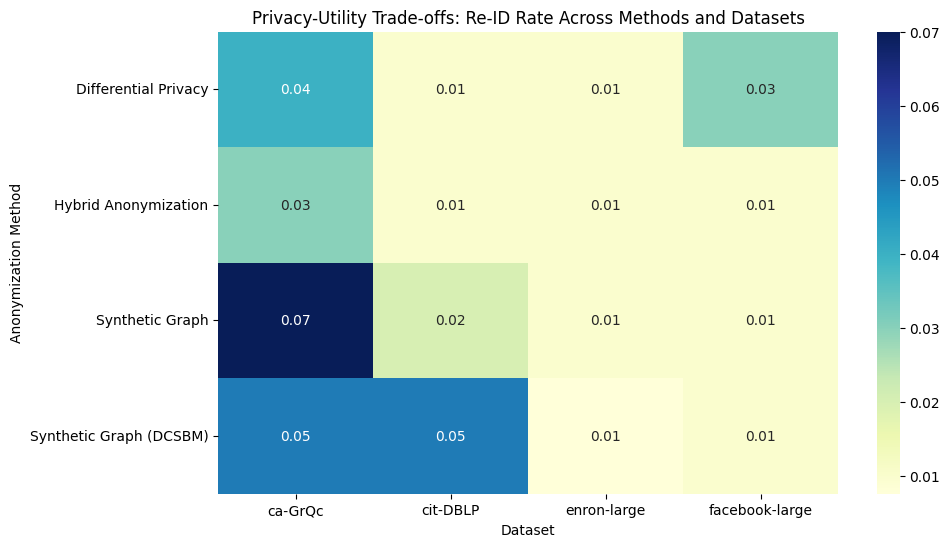

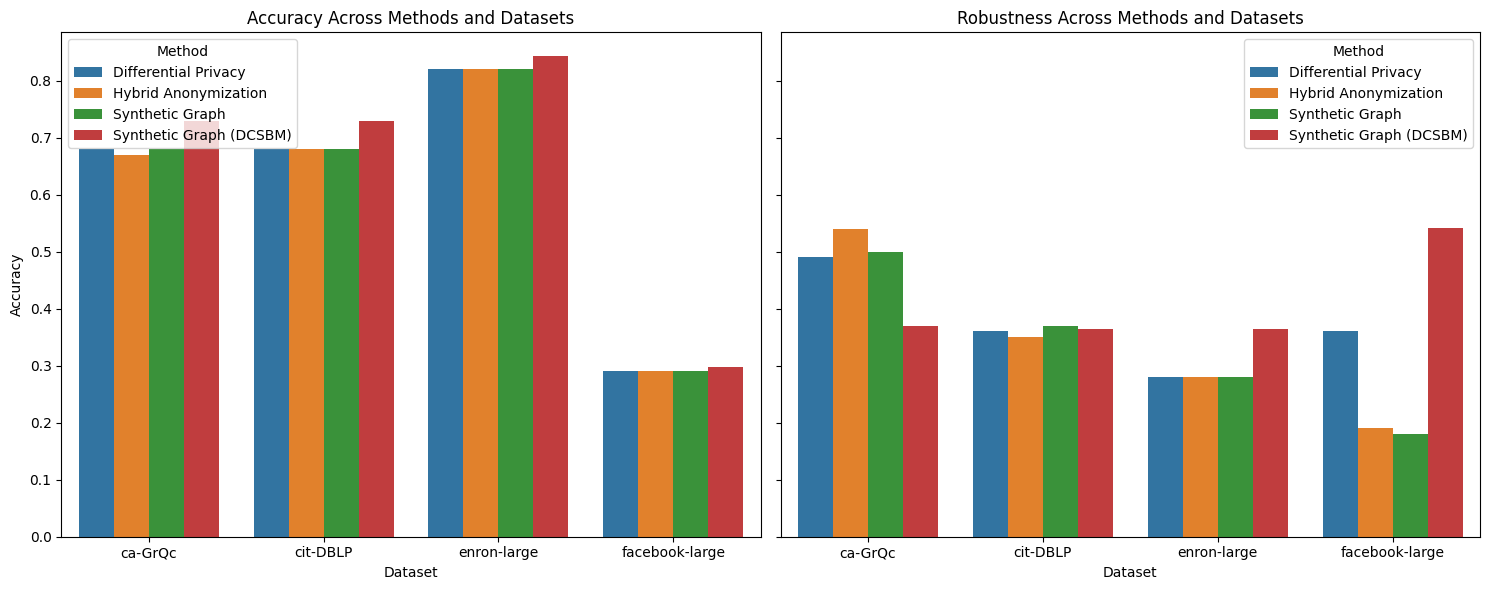

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = {
    'Dataset': ['ca-GrQc', 'ca-GrQc', 'ca-GrQc', 'ca-GrQc',
                'cit-DBLP', 'cit-DBLP', 'cit-DBLP', 'cit-DBLP',
                'enron-large', 'enron-large', 'enron-large', 'enron-large',
                'facebook-large', 'facebook-large', 'facebook-large', 'facebook-large'],
    'Method': ['Differential Privacy', 'Hybrid Anonymization', 'Synthetic Graph', 'Synthetic Graph (DCSBM)'] * 4,
    'Re-ID Rate (%)': [0.04, 0.03, 0.07, 0.05,  # ca-GrQc
                       0.01, 0.01, 0.02, 0.05,  # cit-DBLP
                       0.01, 0.01, 0.01, 0.0076,  # enron-large
                       0.03, 0.01, 0.01, 0.01],  # facebook-large
    'Accuracy': [0.68, 0.67, 0.68, 0.73,  # ca-GrQc
                 0.68, 0.68, 0.68, 0.73,  # cit-DBLP
                 0.82, 0.82, 0.82, 0.8426,  # enron-large
                 0.29, 0.29, 0.29, 0.2983],  # facebook-large
    'Robustness': [0.49, 0.54, 0.50, 0.37,  # ca-GrQc
                   0.36, 0.35, 0.37, 0.3647,  # cit-DBLP
                   0.28, 0.28, 0.28, 0.3647,  # enron-large
                   0.36, 0.19, 0.18, 0.5414],  # facebook-large
    'Modularity Diff.': [0.195, 0.227, 0.199, 0.047,  # ca-GrQc
                         0.0717, 0.0818, 0.0575, 0.0475,  # cit-DBLP
                         0.0919, 0.0931, 0.0906, 0.3899]  # enron-large
                        
}

# Create a DataFrame
df = pd.DataFrame(data)

# Heatmap visualization of Re-ID Rate
heatmap_data = df.pivot_table(index="Method", columns="Dataset", values="Re-ID Rate (%)")

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Privacy-Utility Trade-offs: Re-ID Rate Across Methods and Datasets")
plt.ylabel("Anonymization Method")
plt.xlabel("Dataset")
plt.show()

# Bar chart for Accuracy and Robustness
metrics = ['Accuracy', 'Robustness']
fig, axes = plt.subplots(1, len(metrics), figsize=(15, 6), sharey=True)

for i, metric in enumerate(metrics):
    sns.barplot(data=df, x="Dataset", y=metric, hue="Method", ax=axes[i])
    axes[i].set_title(f"{metric} Across Methods and Datasets")
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel("Dataset")

plt.tight_layout()
plt.show()

# soc-Epinions

In [7]:
def download_and_load_email_enron_graph():
    url = "https://snap.stanford.edu/data/soc-Epinions1.txt.gz"
    file_name = "soc-Epinions1.txt.gz"

    if not os.path.exists(file_name):
        print("Downloading dataset...")
        urllib.request.urlretrieve(url, file_name)

    print("Processing and loading graph...")
    
    edges = []
    with gzip.open(file_name, 'rt') as f:
        for line in f:
            # Skip comments or lines that do not represent edges
            if line.startswith('#') or line.strip() == "":
                continue
            # Split and validate edge definition
            parts = line.strip().split()
            if len(parts) == 2:  # Ensure it's a valid edge
                edges.append(tuple(map(int, parts)))  # Convert node IDs to integers
    
    # Create the graph from the processed edge list
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    
    print(f"Graph loaded with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")
    return graph

### 1. Using differential privacy

In [ ]:
def add_differential_privacy_to_degrees(graph, epsilon=0.3):
    """
    Add differential privacy to the node degrees of a graph with topology-aware noise.

    :param graph: A NetworkX graph.
    :param epsilon: Privacy budget, a smaller epsilon means more privacy.
    :return: A perturbed graph with noisy degrees and edges.
    """
    sensitivity = 1  # Sensitivity of the degree function is 1
    scale = sensitivity / epsilon

    # Create a copy of the graph to perturb
    perturbed_graph = nx.Graph()
    perturbed_graph.add_nodes_from(graph.nodes())

    # Topology-aware noise: Adjust noise based on centrality metrics
    degree_centrality = nx.degree_centrality(graph)
    for node in graph.nodes():
        true_degree = graph.degree[node]
        node_centrality = degree_centrality[node]

        # Scale noise inversely with centrality to obfuscate high-centrality nodes less
        adjusted_scale = scale / (1 + node_centrality)
        noise = np.random.laplace(0, adjusted_scale, 1)[0]  # Generate Laplace noise
        noisy_degree = max(0, int(true_degree + noise))  # Ensure non-negative degree

        # Add or remove edges to achieve noisy degree
        neighbors = list(graph.neighbors(node))
        random.shuffle(neighbors)
        # Add edges
        while len(neighbors) < noisy_degree:
            potential_neighbor = random.choice(list(graph.nodes()))
            if node != potential_neighbor and not perturbed_graph.has_edge(node, potential_neighbor):
                perturbed_graph.add_edge(node, potential_neighbor)
                neighbors.append(potential_neighbor)
        # Remove excess edges if noisy degree is less than the true degree
        while len(neighbors) > noisy_degree:
            neighbor = neighbors.pop()
            if perturbed_graph.has_edge(node, neighbor):
                perturbed_graph.remove_edge(node, neighbor)

    return perturbed_graph

def add_topology_preserving_edges(graph, k=2):
    """
    Add edges to preserve connectivity while obfuscating structure selectively.

    :param graph: A NetworkX graph.
    :param k: Number of random edges to add for each low-centrality node.
    :return: A graph with additional random edges.
    """
    degree_centrality = nx.degree_centrality(graph)
    for node in graph.nodes():
        if degree_centrality[node] < 0.1:  # Focus on low-centrality nodes
            for _ in range(k):
                potential_neighbor = random.choice(list(graph.nodes()))
                if node != potential_neighbor and not graph.has_edge(node, potential_neighbor):
                    graph.add_edge(node, potential_neighbor)

    return graph

def anonymize_and_evaluate(graph):
    epsilon = 0.3  # Moderate privacy budget for better utility-privacy balance

    # Apply differential privacy to the graph
    print("Anonymizing graph with differential privacy...")
    perturbed_graph = add_differential_privacy_to_degrees(graph, epsilon)

    # Add topology-preserving edges
    print("Adding topology-preserving edges...")
    perturbed_graph = add_topology_preserving_edges(perturbed_graph, k=2)

    # Evaluate the anonymized graph
    results = evaluate_graph_anonymization(graph, add_differential_privacy_to_degrees, epsilon=epsilon)
    return results

# Download and preprocess the graph
graph = download_and_load_email_enron_graph()
preprocessed_graph = preprocess_graph(graph)

# Perform anonymization and evaluation
results = anonymize_and_evaluate(preprocessed_graph)

# Print results
print("\nAnonymization Results:")
for key, value in results.items():
    print(f"{key}: {value}")


Processing and loading graph...
Graph loaded with 75879 nodes and 508837 edges.
Starting graph preprocessing...
Checking for isolated nodes...
Checking for self-loops...
Checking for duplicate edges...
No duplicate edges found; the graph is already a simple graph.
Normalizing node IDs...
Ensuring graph is undirected...
Converted to undirected graph.
Preprocessing complete. Graph now has 75879 nodes and 405740 edges.
Anonymizing graph with differential privacy...
Adding topology-preserving edges...
Applying anonymization...
Anonymization completed in 32.28 seconds.
Evaluating privacy preservation...
Measuring privacy preservation...
Edge re-identification rate: 0.00%
Evaluating data utility...
Evaluating data utility...
Original accuracy: 1.00
Anonymized accuracy: 0.84
Evaluating robustness...
Evaluating robustness...
Robustness (degree distribution similarity): 0.25
Evaluating structural similarity...

Anonymization Results:
Anonymization Time: 32.27697396278381
Re-Identification Rate:

### 3. Synthetic Graph

In [10]:
import networkx as nx
import numpy as np
import random
import time
from scipy.stats import powerlaw

# Helper Functions
def generate_synthetic_graph_from_degree_distribution(original_graph):
    """
    Generate a synthetic graph with a matching degree distribution using the Configuration Model.
    """
    degree_sequence = [degree for _, degree in original_graph.degree()]
    synthetic_graph = nx.configuration_model(degree_sequence)
    synthetic_graph = nx.Graph(synthetic_graph)  # Convert to simple graph
    synthetic_graph.remove_edges_from(nx.selfloop_edges(synthetic_graph))
    return synthetic_graph

def add_differential_privacy_to_degrees(graph, epsilon=0.3):
    """
    Add differential privacy to the node degrees of a graph with topology-aware noise.
    """
    sensitivity = 1  # Sensitivity of the degree function is 1
    scale = sensitivity / epsilon

    perturbed_graph = nx.Graph()
    perturbed_graph.add_nodes_from(graph.nodes())
    degree_centrality = nx.degree_centrality(graph)

    for node in graph.nodes():
        true_degree = graph.degree[node]
        node_centrality = degree_centrality[node]
        adjusted_scale = scale / (1 + node_centrality)
        noise = np.random.laplace(0, adjusted_scale, 1)[0]
        noisy_degree = max(0, int(true_degree + noise))

        neighbors = list(graph.neighbors(node))
        random.shuffle(neighbors)

        while len(neighbors) < noisy_degree:
            potential_neighbor = random.choice(list(graph.nodes()))
            if node != potential_neighbor and not perturbed_graph.has_edge(node, potential_neighbor):
                perturbed_graph.add_edge(node, potential_neighbor)
                neighbors.append(potential_neighbor)

        while len(neighbors) > noisy_degree:
            neighbor = neighbors.pop()
            if perturbed_graph.has_edge(node, neighbor):
                perturbed_graph.remove_edge(node, neighbor)

    return perturbed_graph

def hybrid_anonymization(graph, epsilon=0.3):
    """
    Combine differential privacy with edge-swapping for hybrid anonymization.
    """
    perturbed_graph = add_differential_privacy_to_degrees(graph, epsilon)
    edges = list(perturbed_graph.edges())
    random.shuffle(edges)
    num_swaps = len(edges) // 10

    for _ in range(num_swaps):
        edge1 = random.choice(edges)
        edge2 = random.choice(edges)
        u1, v1 = edge1
        u2, v2 = edge2

        if len(set([u1, v1, u2, v2])) == 4:
            if perturbed_graph.has_edge(u1, v1) and perturbed_graph.has_edge(u2, v2):
                perturbed_graph.remove_edge(u1, v1)
                perturbed_graph.remove_edge(u2, v2)
                perturbed_graph.add_edge(u1, u2)
                perturbed_graph.add_edge(v1, v2)

    return perturbed_graph

def anonymize_and_evaluate_with_synthetic_graph(original_graph, epsilon=0.3):
    """
    Main workflow to anonymize using synthetic graph and evaluate the results.
    """
    print("Generating synthetic graph...")
    synthetic_graph = generate_synthetic_graph_from_degree_distribution(original_graph)

    print("Applying differential privacy to synthetic graph...")
    start_time = time.time()
    anonymized_graph = hybrid_anonymization(synthetic_graph, epsilon)
    anonymization_time = time.time() - start_time
    print(f"Anonymization completed in {anonymization_time:.2f} seconds.")

    print("\nEvaluating graph anonymization...")
    results = evaluate_graph_anonymization(original_graph, hybrid_anonymization, epsilon=epsilon)
    results["Anonymization Time"] = anonymization_time

    return anonymized_graph, results


print("\nApplying hybrid anonymization with synthetic graph...")
anonymized_graph, results = anonymize_and_evaluate_with_synthetic_graph(preprocessed_graph, epsilon=0.3)

print("\nFinal Evaluation Results:")
for key, value in results.items():
    print(f"{key}: {value}")


Applying hybrid anonymization with synthetic graph...
Generating synthetic graph...
Applying differential privacy to synthetic graph...
Anonymization completed in 32.51 seconds.

Evaluating graph anonymization...
Applying anonymization...
Anonymization completed in 33.04 seconds.
Evaluating privacy preservation...
Measuring privacy preservation...
Edge re-identification rate: 0.00%
Evaluating data utility...
Evaluating data utility...
Original accuracy: 1.00
Anonymized accuracy: 0.84
Evaluating robustness...
Evaluating robustness...
Robustness (degree distribution similarity): 0.25
Evaluating structural similarity...

Final Evaluation Results:
Anonymization Time: 32.507253885269165
Re-Identification Rate: 0.002957559027948933
Original Accuracy: 1.0
Anonymized Accuracy: 0.8350795345220681
Robustness Score: 0.2480849805294031
Degree Distribution Correlation: 0.004593858100746144
Clustering Coefficient Correlation: 0.0043810175048650465
Triangles Similarity: -0.0016571119746557105
Modula